# CELLECT Analyzer tool 

Tool to analyse CELLECT output prioritization files.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path # to search for the .cvs files
# import time
# from sklearn.metrics import r2_score
# from matplotlib_venn import venn2
# from collections import Counter
%matplotlib inline
# %matplotlib notebook
# %matplotlib nbagg
from matplotlib_venn import venn3
import itertools
# from scipy.stats import spearmanr # calculate correlation
from scipy.stats import pearsonr # calculate correlation
from adjustText import adjust_text
from statsmodels.stats.multitest import multipletests 
import re
import upsetplot
from circosplot import Gcircle

## Functions

In [2]:
def csv_file(directory):
    file_dict = {}
    for path in Path(directory).rglob('prioritization.csv'):
        full_path = str(path)
        (name, method,__, __) = path.parts[-4:]
        name = name[8:] # CELLECT- is 8 long
        method = method[8:]
        if name not in file_dict:
            file_dict[name] = {}
        file_dict[name].update({method:full_path})
    return file_dict

# def csv_file(directory):
#     '''Searches for all prioritization.csv in the directory. 
#     This assumes that the .csv files are in a 'CELLECT-' folder for correct parsing,
#     and that these folders are in another folder which is how the data will be referenced to.'''
#     file_dict = {}
#     for path in Path(directory).rglob('prioritization.csv'):
#         full_path = str(path)
#         (name, method, __) = path.parts[-3:]
#         method = method[8:]# CELLECT- is 8 long
#         if name not in file_dict:
#             file_dict[name] = {}
#         file_dict[name].update({method:full_path})
#     return file_dict

def make_df(directory):
    '''Make a DataFrama for the .csv files.'''
    file_dict = csv_file(directory)
    df_list_1 = []
    for name,d in file_dict.items():
        df_list_2 = []
        for method, file_path in d.items():
            df = pd.read_csv(file_path)
            df['method'] = method
            df.sort_values(by=['gwas','specificity_id','annotation'], inplace=True)
            df_list_2.append(df)
        df_list_1.extend(df_list_2)
    df_all = pd.concat(df_list_1, ignore_index=True)

#     df_all['-log10(p)'] = df_all['pvalue'].apply(lambda x : -1*np.log10(x))
    # count the number of methods used (MAGMA/H-MAGMA/LDSC)
    df_all = df_all.merge(df_all.groupby(['gwas','specificity_id','annotation']).size()\
                            .to_frame('n_methods'), on=['gwas','specificity_id','annotation'], how='left')
    # count the number of annotations/celltypes
#     df_all = df_all.merge(df_all.groupby(['gwas','specificity_id']).size()\
#                             .to_frame('n_annotations'), on=['gwas','specificity_id'],how='left')
#     df_all['n_annotations'] = (df_all['n_annotations'] / df_all['n_methods']).astype(int)
#     df_all['pthres'] = 0.05 / df_all['n_annotations'] # Bonferroni correction      
    df_all.sort_values(by=['gwas','method'], inplace=True)
    df_all.reset_index(inplace=True, drop=True)
    return df_all                        
                        
def make_filename(filename):
    return filename.replace(' ','_').replace(':','')
                       
def pvalue_correction(dataframe, method='bonferroni'):
    '''
    Available methods can be found at
    https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html
    '''
    df_p = dataframe.pivot_table(values='pvalue', index=['method','gwas','specificity_id',],
                                     columns=['annotation'])
    df_p = df_p.apply(lambda row: multipletests(row.dropna(), method=method)[1],
                   axis=1,
                   result_type='reduce'
                  ).apply(pd.Series).stack().reset_index().drop('level_3', axis=1)\
    .rename(columns={0:f"pvalue_{method}"})
    df_p['annotation'] = dataframe['annotation']
    return pd.merge(dataframe, df_p, on=['gwas','specificity_id','annotation','method'])

## Search all prioritization.csv files and makes a df containing all entries

In [3]:
SEARCH_PRIORI = False

out_dir = 'out/'
# files_dir = 'data/CELLECT'
files_dir = '/home/eerdem/CELLECT-revised/out/'

methods = ['H-MAGMA','LDSC', 'MAGMA']
method_color = {'H-MAGMA':'#4A148C',
                'LDSC':'#CE93D8',
                'MAGMA':'#9C27B0'}
pval_correction = 'bonferroni'
# pval_correction = 'fdr_bh'
if MAKE_NEW_DATAFRAME:
    df_all = make_df(CELLECT_OUTDIR)
    df_all = pvalue_correction(df_all, method=PVAL_CORRECTION)

if SEARCH_PRIORI:
    df_all = make_df(files_dir)
    df_all = pvalue_correction(df_all, method=pval_correction)

    # make gwas column more interpretable by merging with metadata

    pd.options.mode.chained_assignment = None  # default='warn' 
    keep_col = df_all.columns.tolist()

    #cortical
    phenotypes_cort = {
                "Frontal": ["superiorfrontal", "rostralmiddlefrontal", "caudalmiddlefrontal", "parsopercularis", "parstriangularis","parsorbitalis", "lateralorbitofrontal", "medialorbitofrontal", "precentral", "paracentral", "frontalpole"],
                "Temporal": ["superiortemporal", "middletemporal", "inferiortemporal", "bankssts", "fusiform", "transversetemporal","entorhinal", "temporalpole", "parahippocampal"],
                "Parietal": ["superiorparietal", "inferiorparietal", "supramarginal", "postcentral", "precuneus"  ],
                "Occipital": ["lateraloccipital", "lingual", "cuneus", "pericalcarine"],
                "Cingulate": ["rostralanteriorcingulate", "caudalanteriorcingulate", "posteriorcingulate", "isthmuscingulate"],
                "Insula": ["insula"],  
                "Cortex": ['cortex']
                }
    model_cort = {
            "model1a": "surface area",
            "model1b": "cortical thickness (adjusted)",
            "model1c": "cortical thickness",
            "model1d": "volume" 
            }
    inv_map_pheno = {v:k for k,v_list in phenotypes_cort.items() for v in v_list}
    df_cort = df_all[df_all.gwas.str.contains('model1\w_\w+')]
    df_drop = df_all.drop(df_cort.index)
    df_cort[['model', 'sub_region']] = df_cort.gwas.str.split('_',expand=True)
    df_cort['region'] = [inv_map_pheno[sr] for sr in df_cort.sub_region]
    df_cort['model'] = [model_cort[m] for m in df_cort.model]
    df_cort['gwas'] = df_cort[['model','region','sub_region']].apply(
                            lambda x: f'{x[0]}: {x[1]}.{x[2]}', axis=1)
    df_cort = df_cort[keep_col]
    #DTI
    meta_dti = pd.read_csv('data/CELLECT/BIG-S2_DTI2020/DTI.csv', usecols=[0,1])
    meta_dti[['type','pheno']] = meta_dti['assoc_files'].str.extract(r'_(\w+)_pheno(\d+)', expand=True)
    DTI_params_dict = {'FA':'fractional anisotropy', 'MD':'mean diusivities',
                       'AD':'axial diusivities', 'RD':'radial diusivities', 'MO':'mode of anisotropy',
                       'PC1':'PC1', 'PC2':'PC2','PC3':'PC3','PC4':'PC4','PC5':'PC5'
                      }
    WM_params_dict = {'ID':'Full Name','ACR':'Anterior corona radiata','ALIC':'Anterior limb of internal capsule',
                      'BCC':'Body of corpus callosum','CGC':'Cingulum (cingulate gyrus)',
                      'CGH':'Cingulum (hippocampus)','CST':'Corticospinal tract','EC':'External capsule',
                      'FX':'Fornix (column and body of fornix)',
                      'FXST':'Fornix (cres) / Stria terminalis (can not be resolved with current resolution)',
                      'GCC':'Genu of corpus callosum','IFO':'Inferior fronto-occipital fasciculus',
                      'PCR':'Posterior corona radiata','PLIC':'Posterior limb of internal capsule',
                      'PTR':'Posterior thalamic radiation (include optic radiation)',
                      'RLIC':'Retrolenticular part of internal capsule',
                      'SCC':'Splenium of corpus callosum','SCR':'Superior corona radiata',
                      'SFO':'Superior fronto-occipital fasciculus (could be a part of anterior internal capsule)',
                      'SLF':'Superior longitudinal fasciculus',
                      'SS':'Sagittal stratum (include inferior longitidinal fasciculus and inferior fronto-occipital fasciculus)',
                      'UNC':'Uncinate fasciculus','Average':'Whole brain average across all tracts'}

    df_dti = df_all[df_all.gwas.str.contains('ukb_phase1to3')]
    df_drop.drop(df_dti.index, inplace=True)
    df_dti[['type','pheno']] = df_dti['gwas'].str.extract(r'ukb_phase1to3_(\w+\d*)_dec21_2019_pheno(\d+)',expand=True)
    df_dti = df_dti.replace({'type':{'dti441':'mean', 'fapcs':'fpc'}})
    df_dti = pd.merge(df_dti, meta_dti, on=['type','pheno'])
    df_dti[['WM_tract','DTI_param']] = df_dti['phenocode'].str.split('_', expand=True)
    df_dti['gwas'] = df_dti[['WM_tract','DTI_param']].apply(
                            lambda x: f'DTI {x[1]}: {x[0]}', axis=1)
    df_dti = df_dti[keep_col]

    #subcortical
    df_subcor = df_all[df_all.gwas.str.contains('fixed_\w+_MEGAMETA')]
    df_drop.drop(df_subcor.index, inplace=True)
    df_subcor['gwas'] = 'volume: '+df_subcor.gwas.str.extract(r'fixed_(\w+)_MEGAMETA', expand=True)

    #hippocampus volume
    df_hipp = df_all[df_all.gwas.str.contains('hippocampus2019')]
    df_drop.drop(df_hipp.index, inplace=True)
    df_hipp['gwas'] = ('volume: Hippocampus.'+df_all[df_all.gwas.str.contains('hippocampus2019')]['gwas']\
               .str.extract(r'ROIvolume_(\w+)_',expand=True))


    df_meta_concat = pd.concat([df_cort, df_dti, df_subcor, df_hipp], ignore_index=False)
    df_all_adjusted = pd.concat([df_drop,df_meta_concat])

    # drop test stuff
    drop_rows = ['mousebrain-test','tabula_muris-test','human_m10_10x'] 
    df_all = df_all_adjusted[~df_all_adjusted.specificity_id.isin(drop_rows)]
    
    df_all.to_csv(f'{out_dir}df_all.csv', index=False)


NameError: name 'MAKE_NEW_DATAFRAME' is not defined

In [4]:
df_all = pd.read_csv(f'{out_dir}df_all.csv')
df_all[df_all.gwas.str.contains('HV')]

,gwas,specificity_id,annotation,beta,beta_se,pvalue,method,n_methods,pvalue_bonferroni
358065,HV_2016,Allen_human_LGN,GABAergic.LGN_Inh_CTXN3,-0.108603,0.082503,0.905957,H-MAGMA,3,1.000000
358066,HV_2016,Allen_human_LGN,GABAergic.LGN_Inh_LAMP5,0.051228,0.066909,0.221957,H-MAGMA,3,1.000000
358067,HV_2016,Allen_human_LGN,GABAergic.LGN_Inh_NTRK1,-0.070860,0.082087,0.805986,H-MAGMA,3,1.000000
358068,HV_2016,Allen_human_LGN,GABAergic.LGN_Inh_TRPC4,0.064120,0.092153,0.243283,H-MAGMA,3,1.000000
358069,HV_2016,Allen_human_LGN,Glutamatergic.LGN_Exc_BTNL9,0.010619,0.123406,0.465713,H-MAGMA,3,1.000000
...,...,...,...,...,...,...,...,...,...
359695,HV_2016,tabula_muris,Tongue.keratinocyte,-0.079302,0.046178,0.957026,MAGMA,3,1.000000
359696,HV_2016,tabula_muris,Trachea.blood_cell,-0.040122,0.060255,0.747249,MAGMA,3,1.000000
359697,HV_2016,tabula_muris,Trachea.endothelial_cell,0.009726,0.056555,0.431733,MAGMA,3,1.000000
359698,HV_2016,tabula_muris,Trachea.epithelial_cell,-0.052223,0.053672,0.834713,MAGMA,3,1.000000


In [19]:
df_temp = df_all[(df_all.specificity_id.str.contains('Descartes'))&(df_all.pvalue_bonferroni<=0.05)].groupby(['gwas','annotation'])['method'].count().to_frame()

In [30]:
df_temp[df_temp['method']>2].drop(columns='method').reset_index().to_excel('descartes_all_methods_significant.xlsx')

In [20]:
df_all.to_hdf('/home/eerdem/CELLECT-revised/data/CELLECT_output/data.h5', key='df_all', mode='w')

In [18]:
pd.read_hdf('/home/eerdem/CELLECT-revised/data/CELLECT_output/df_all.h5', 'df')


,gwas,specificity_id,annotation,beta,beta_se,pvalue,method,n_methods,pvalue_bonferroni
0,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_CTXN3,-0.174645,0.089013,0.975106,H-MAGMA,3,1.0
1,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_LAMP5,-0.123540,0.071732,0.957472,H-MAGMA,3,1.0
2,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_NTRK1,-0.269440,0.088436,0.998840,H-MAGMA,3,1.0
3,AD_JANSENS2019,Allen_human_LGN,GABAergic.LGN_Inh_TRPC4,-0.246886,0.099982,0.993223,H-MAGMA,3,1.0
4,AD_JANSENS2019,Allen_human_LGN,Glutamatergic.LGN_Exc_BTNL9,-0.421298,0.133637,0.999188,H-MAGMA,3,1.0
...,...,...,...,...,...,...,...,...,...
879625,volume: thalamus,tabula_muris,Tongue.keratinocyte,-0.035636,0.045386,0.783817,MAGMA,3,1.0
879626,volume: thalamus,tabula_muris,Trachea.blood_cell,-0.102483,0.059198,0.958279,MAGMA,3,1.0
879627,volume: thalamus,tabula_muris,Trachea.endothelial_cell,-0.114722,0.055573,0.980498,MAGMA,3,1.0
879628,volume: thalamus,tabula_muris,Trachea.epithelial_cell,-0.102770,0.052743,0.974312,MAGMA,3,1.0


## Beta Correlation

In [22]:
def calculate_pearson(dataframe):
    corr_list = []
    pval_list = []
    gwas_list = dataframe.columns.values
    for x,y in itertools.combinations(dataframe.columns, 2):
        corr, pval =  pearsonr(dataframe.loc[:,x].values, dataframe.loc[:,y].values)
        corr_list.append([x,y,corr])
        pval_list.append([x,y,pval])
    corr_list_with_diag = corr_list + [[gwas, gwas, 1] for gwas in gwas_list]
    pval_list_with_diag = pval_list + [[gwas, gwas, 0] for gwas in gwas_list]
    corr_df = pd.DataFrame(corr_list_with_diag, columns=['gwasx','gwasy','corr']).pivot(index='gwasx',
                                                                                        columns='gwasy',
                                                                                        values='corr')
    pval_df = pd.DataFrame(pval_list_with_diag, columns=['gwasx','gwasy','pval']).pivot(index='gwasx',
                                                                                        columns='gwasy',
                                                                                        values='pval')
    return corr_df, pval_df

def correct_pval_correlation(pval_df):
    '''Uses Bonferroni correction for the input correlation pvalues.'''
    n = pval_df.shape[0]
    n_test = (n*(n-1)/2)
    corrected_pval_df = pval_df * n_test
    corrected_pval_df[corrected_pval_df > 1] = 1
    return corrected_pval_df

    
def calculate_pearson(dataframe, with_diag=False):
    corr_list = []
    gwas_list = dataframe.columns.values
    for x,y in itertools.combinations(dataframe.columns, 2):
        corr, pval =  pearsonr(dataframe.loc[:,x].values, dataframe.loc[:,y].values)
        corr_list.append([x,y,corr, pval])
    if with_diag:
        corr_list = corr_list + [[gwas, gwas, 1, 0] for gwas in gwas_list]
    corr_df = pd.DataFrame(corr_list, columns=['gwasx','gwasy','corr','pval'])
    return corr_df

def get_pthres(corr_df):
    return corr_df[corr_df['corr']<0]['pval'].min()

In [23]:
df_list = []
for m in methods:
    df_method = df_all[(df_all.method==m)]
    df_method_pivot = df_method.pivot_table(index='annotation', columns='gwas', values='beta')
    df_method_pivot.dropna(axis='columns',inplace=True) #drop gwas if not complete
    corr_df = calculate_pearson(df_method_pivot)
    corr_df['method'] = m
    df_list.append(corr_df)
corr_df = pd.concat(df_list)
corr_df.to_hdf('/home/eerdem/CELLECT-revised/data/CELLECT_output/data.h5', key='corr_df')

,gwasx,gwasy,corr,pval,method
0,AD_JANSENS2019,ASD_2019,-0.220065,2.278355e-07,H-MAGMA
1,AD_JANSENS2019,BIP_PGC3,-0.122407,4.318468e-03,H-MAGMA
2,AD_JANSENS2019,BMI_GIANT2018,-0.007513,8.614700e-01,H-MAGMA
3,AD_JANSENS2019,DTI AD: ACR,0.247713,5.065423e-09,H-MAGMA
4,AD_JANSENS2019,DTI AD: ALIC,0.234532,3.299649e-08,H-MAGMA
...,...,...,...,...,...
144448,volume: caudate,volume: putamen,0.337825,6.184427e-16,MAGMA
144449,volume: caudate,volume: thalamus,0.351890,3.040520e-17,MAGMA
144450,volume: pallidum,volume: putamen,0.256756,1.313908e-09,MAGMA
144451,volume: pallidum,volume: thalamus,0.310798,1.330849e-13,MAGMA


In [26]:
corr_df.to_hdf('/home/eerdem/CELLECT-revised/data/CELLECT_output/data.h5', key='corr_df')

In [19]:
%%time 
corr_pears_methods_dict = {}
for m in methods:
    df_method = df_all[(df_all.method==m)]
    df_method_pivot = df_method.pivot_table(index='annotation', columns='gwas', values='beta')
    df_method_pivot.dropna(axis='columns',inplace=True) #drop gwas if not complete
    corr_df = calculate_pearson(df_method_pivot)
    corr_pears_methods_dict[m] = corr_df
#     break
display(corr_df)

,gwasx,gwasy,corr,pval
0,AD_JANSENS2019,ASD_2019,-0.211104,7.073597e-07
1,AD_JANSENS2019,BIP_PGC3,-0.078602,6.747103e-02
2,AD_JANSENS2019,BMI_GIANT2018,-0.088627,3.914903e-02
3,AD_JANSENS2019,DTI AD: ACR,0.379249,5.535500e-20
4,AD_JANSENS2019,DTI AD: ALIC,0.267161,2.605121e-10
...,...,...,...,...
144448,volume: caudate,volume: putamen,0.337825,6.184427e-16
144449,volume: caudate,volume: thalamus,0.351890,3.040520e-17
144450,volume: pallidum,volume: putamen,0.256756,1.313908e-09
144451,volume: pallidum,volume: thalamus,0.310798,1.330849e-13


CPU times: user 1min 1s, sys: 0 ns, total: 1min 1s
Wall time: 1min 1s


In [18]:
get_pthres(corr_df)

2.6589484501493723e-27

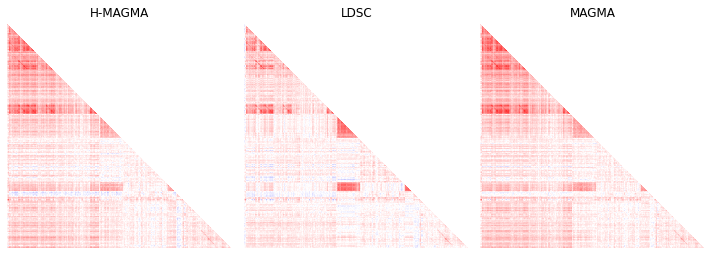

In [30]:
fig, axes = plt.subplots(1,3, figsize=(10,4))
for m,ax in zip(methods, axes.flatten()):
    corr_df = corr_pears_methods_dict[m]

    ax.imshow(corr_df[['gwasx','gwasy','corr']].pivot(columns='gwasx', index='gwasy'),
              cmap='bwr', vmin=-1, vmax=1)
    ax.set_title(m)
    ax.set_axis_off()
plt.tight_layout()

In [486]:
corr_pears_methods_dict[m]

,gwasx,gwasy,corr,pval
0,AD_JANSENS2019,ASD_2019,-0.211104,7.073597e-07
1,AD_JANSENS2019,BIP_PGC3,-0.078602,6.747103e-02
2,AD_JANSENS2019,BMI_GIANT2018,-0.088627,3.914903e-02
3,AD_JANSENS2019,DTI AD: ACR,0.379249,5.535500e-20
4,AD_JANSENS2019,DTI AD: ALIC,0.267161,2.605121e-10
...,...,...,...,...
144448,volume: caudate,volume: putamen,0.337825,6.184427e-16
144449,volume: caudate,volume: thalamus,0.351890,3.040520e-17
144450,volume: pallidum,volume: putamen,0.256756,1.313908e-09
144451,volume: pallidum,volume: thalamus,0.310798,1.330849e-13


In [515]:
df_list = []
from functools import reduce

for m in methods:
    corr_df = corr_pears_methods_dict[m]
    df_list.append(corr_df[corr_df['pval']<get_pthres(corr_df)][['gwasx','gwasy','corr']].rename(columns=
                                                                                                 {'corr':m}))
#     break
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['gwasx','gwasy'],
                                               how='outer'), df_list)
df_merged.dropna(inplace=True)
df_merged = df_merged.assign(mean=lambda x: x.mean(axis=1)).sort_values('mean', ascending=False)
df_merged['std'] = df_merged[[m for m in methods]].std(axis=1)
# df_merged.to_excel('ct_corr.xlsx', index=False)
df_merged[~((df_merged['gwasx'].str.contains('DTI'))&(df_merged['gwasy'].str.contains('DTI')))].head(30)

,gwasx,gwasy,H-MAGMA,LDSC,MAGMA,mean,std
5723,SCZ_2014,SCZ_2016,0.949705,0.979146,0.963577,0.964142,0.014729
5726,SCZ_2016,SCZ_PGC3_2020,0.935639,0.963984,0.962636,0.954086,0.015990
5724,SCZ_2014,SCZ_PGC3_2020,0.933422,0.965259,0.959647,0.952776,0.016994
38,BIP_PGC3,SCZ_PGC3_2020,0.870584,0.851139,0.889868,0.870531,0.019365
37,BIP_PGC3,SCZ_2016,0.834464,0.849596,0.876771,0.853610,0.021438
36,BIP_PGC3,SCZ_2014,0.834497,0.838090,0.861508,0.844698,0.014668
5432,Net100_Node19,Net25_Node20,0.794308,0.853617,0.766068,0.804664,0.044684
60,BMI_GIANT2018,SCZ_PGC3_2020,0.845410,0.710721,0.817630,0.791254,0.071113
59,BMI_GIANT2018,SCZ_2016,0.819969,0.684438,0.832091,0.778833,0.081973
58,BMI_GIANT2018,SCZ_2014,0.819911,0.677883,0.806654,0.768149,0.078453


In [618]:
df_all[(df_all.method==m)
                       &
                       (df_all['gwas'].str.contains('PGC|BMI'))
                      ].gwas.unique()

array(['BIP_PGC3', 'BMI_GIANT2018', 'PGC_depression2019', 'SCZ_PGC3_2020'],
      dtype=object)

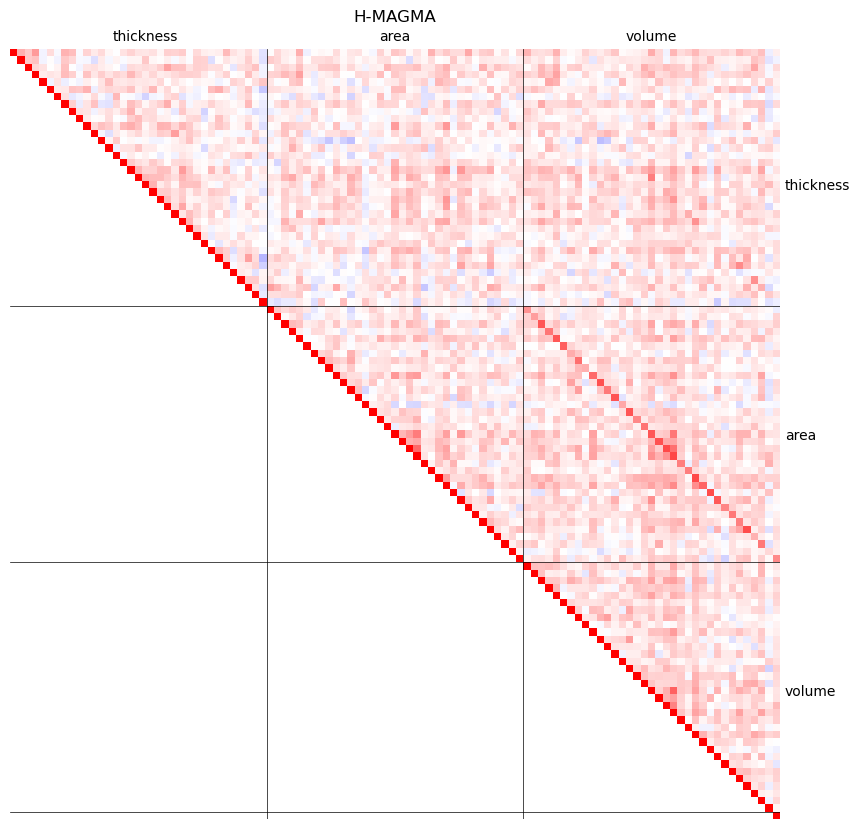

In [609]:
plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(10,10))
# for m,ax in zip(methods, axes.flatten()):
for m in methods:
    m = 'H-MAGMA'
#     df_method = df_all[(df_all.method==m)&(df_all.gwas.str.contains('DTI'))]
#     corr_df = corr_df[(corr_df['gwasx'].str.contains('DTI'))&(corr_df['gwasy'].str.contains('DTI'))]
#     df_method = df_all[(df_all.method==m)&(df_all.gwas.str.contains('volume|surface|thickness'))].copy()
    df_method = df_all[(df_all.method==m)
                       &
                       (df_all['gwas'].str.contains(': \w+\.\w+'))
                      ].copy()
    df_method = df_method[~df_method['gwas'].str.contains('Hippocampus')]
    df_method_pivot = df_method.pivot_table(index='annotation', columns='gwas', values='beta')
    df_method_pivot.dropna(axis='columns',inplace=True) #drop gwas if not complete
    corr_df = calculate_pearson(df_method_pivot, with_diag=True)
#     corr_df = corr_pears_methods_dict[m].copy()
#     corr_df = corr_df[(corr_df['gwasx'].str.contains('DTI'))&(corr_df['gwasy'].str.contains('DTI'))]
    corr_df = corr_df.pivot(columns='gwasy', index='gwasx', values='corr')
    ax.imshow(corr_df,
              cmap='bwr', vmin=-1, vmax=1)
    ax.set_title(m)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
#     yticks = corr_df.index.str.split(':').str[0].str.split(' ').str[-1].to_list()
    yticks = corr_df.index.str.split(':').str[0].str.split('(').str[0].str.rstrip().str.split(' ').str[-1]
    ticks = ['']*len(yticks)
    for group in set(yticks):
        start = False
        end = False
        for i,tick in enumerate(yticks):
            if tick==group and start==False:
                start = i
            if start and tick!=group:
                end = i
                break
        if end == False:
            end = i
#         ax.axvline(end, color='k', lw=0.5)
        ax.axhline(end-.5, color='k', lw=0.5)
        mid = int((end+start)/2)   
    #     print(group, start, end, mid)
        ticks[mid] = group
    ax.axvline(35-.5, color='k', lw=0.5)
    ax.axvline(70-.5, color='k', lw=0.5)
    ax.yaxis.tick_right()
    ax.set_yticks(list(range(0,corr_df.shape[0])))
    ax.set_yticklabels(ticks)
    ax.xaxis.tick_top()
    ax.set_xticks(list(range(0,corr_df.shape[0])))
    ax.set_xticklabels(ticks)
    break
#     plt.show()
# plt.tight_layout()


In [439]:
for group in set(yticks):
    start = False
    end = False
    for i,tick in enumerate(yticks):
        if tick==group and start==False:
            start = i
        if start and tick!=group:
            end = i
            break
    if end == False:
        end = i
#         ax.axvline(start, color='k', lw=0.5)
#         ax.axhline(end, color='k', lw=0.5)
#         mid = int((end+start)/2)   
    print(group, start, end, mid)

PC3 130 151 98
AD 1 22 98
PC4 151 172 98
MO 66 88 98
PC2 109 130 98
MD 44 66 98
PC5 172 193 98
FA 22 44 98
RD 193 213 98
PC1 88 109 98


In [20]:
# # calculate all pearson correlation and pvalues
# corr_pears_methods_dict = {}
# pval_pears_methods_dict = {}

# for m in methods:
#     df_method = df_all[(df_all.method==m)]
    
#     df_method_pivot = df_method.pivot_table(index='annotation', columns='gwas', values='beta')
#     df_method_pivot.dropna(axis='columns',inplace=True) #drop gwas if not complete

#     corr_df, pval_df = calculate_pearson(df_method_pivot)
#     corr_pears_methods_dict[m] = corr_df
#     pval_pears_methods_dict[m] = pval_df
    

In [31]:
# fig, axes = plt.subplots(1,3, figsize=(10,4))
# for m,ax in zip(methods, axes.flatten()):
#     corr_df = corr_pears_methods_dict[m]
# #     pval_df = pval_pears_methods_dict[m]
# #     pval_corrected_df = correct_pval_correlation(pval_df) # Bonferroni   
# #     sign_pval_df = pval_corrected_df <= 0.05
# #     sign_pval_df.replace({True:'*', False:''}, inplace=True)
    
#     ax.imshow(corr_df, cmap='bwr', vmin=-1, vmax=1)
#     ax.set_title(m)
#     ax.set_axis_off()
# plt.tight_layout()

(293210,)
(293210,)
(293210,)


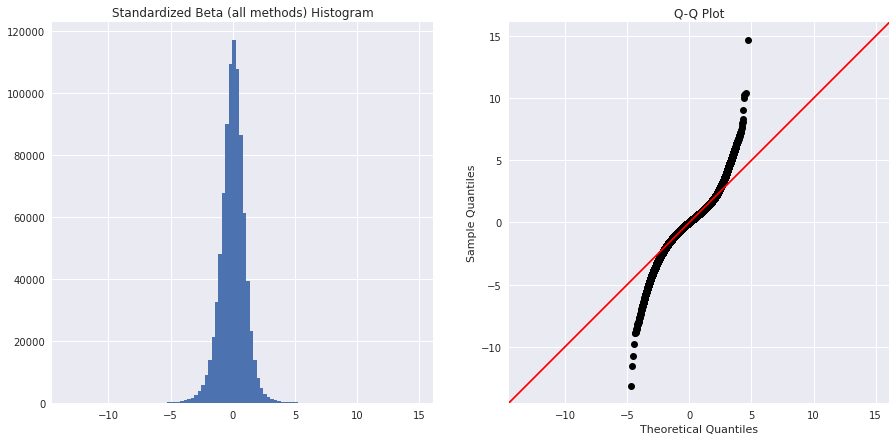

In [22]:
import statsmodels.api as sm
plt.style.use('seaborn')
norm_data = {}
for m in methods:
    data = df_all[(df_all['method']==m)
#                  &(df_all.specificity_id!='tabula_muris')
                 ]['beta']
    norm_data[m] = (data-data.mean())/data.std()
    print(data.shape)
#     norm_data[m].hist(figsize=(10,5), bins=100)
#     sm.qqplot(norm_data[m], line='45', color='k')
#     plt.xlim((-10,10))
#     plt.ylim((-10,10))
#     plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,7))
final_data = pd.concat(norm_data.values())
final_data.hist(bins=100, ax=ax[0])
ax[0].set_title('Standardized Beta (all methods) Histogram')
sm.qqplot(final_data, line='45', color='k', ax=ax[1])
ax[1].set_title('Q-Q Plot')
plt.show()


In [23]:
for m in methods:
    data = df_all[(df_all['method']==m)]['beta']
    norm_data = (data-data.mean())/data.std()
    fraction = sum((data<0)==(norm_data<0)) / len(data)
    print(m, fraction)

H-MAGMA 0.8572320180075713
LDSC 0.991388424678558
MAGMA 0.9103782272091675


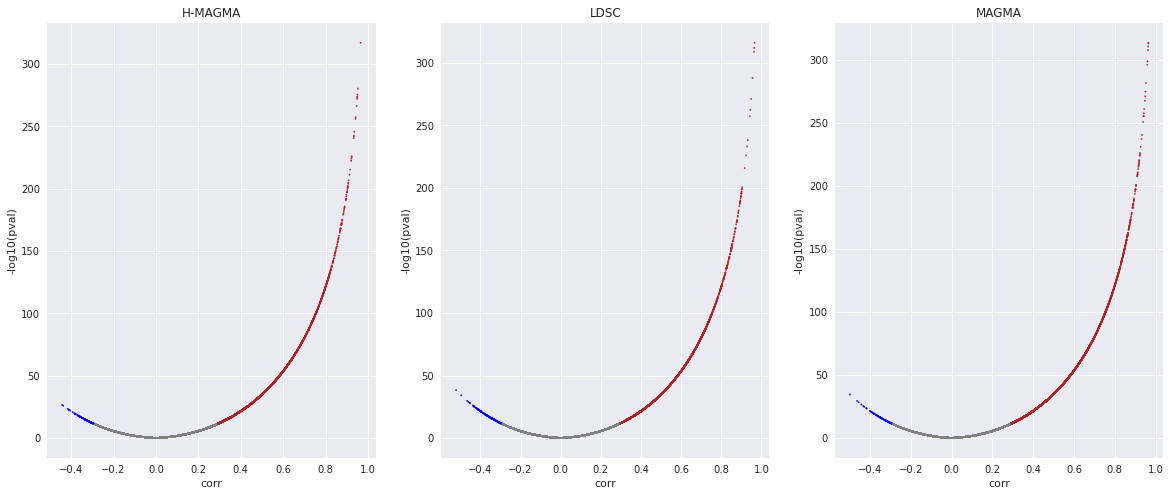

In [32]:
plt.style.use('seaborn')
def bluered_cmap_pval(array):
    cmap = []
    n = array.shape[0]
    n_test = (n*(n-1)/2)
    pthres = 0.05 / n_test
    for p,c in zip(array['pval'], array['corr']):
        if p <= pthres and c > 0:
            color = 'firebrick'
        elif p <= pthres and c < 0:
            color = 'blue'
        else:
            color = 'gray'
        cmap.append(color)
    return cmap


fig, axes = plt.subplots(1,3, figsize=(20,8))
for m,ax in zip(methods, axes.flatten()):
    corr_df = corr_pears_methods_dict[m].copy()
    corr_df['-log10(pval)'] =  corr_df['pval'].apply(lambda x : -1*np.log10(x)).replace(np.inf, np.nan)
    corr_df.dropna(inplace=True)
    cmap = bluered_cmap_pval(corr_df)
    corr_df.plot.scatter(x='corr', y='-log10(pval)', ax=ax, s=2, c=cmap)
    ax.set_title(m)
#     ax.axhline(-np.log10(0.05))
#     break

# check
# file://storage.erasmusmc.nl/m/MyDocs/057480/My%20Documents/Desktop/media-1.pdf
# figure 21 to compare the plots

In [ ]:
# # big heatmap with all gwases labelled (maybe? havent run yet...)
# PLOT_HEATMAP = False
# if PLOT_HEATMAP:
#     for m in methods:
#         corr_df = corr_pears_methods_dict[m]
#         pval_df = pval_pears_methods_dict[m]
#         pval_corrected_df = correct_pval_correlation(pval_df) # Bonferroni   
#         sign_pval_df = pval_corrected_df <= 0.05
#         sign_pval_df.replace({True:'*', False:''}, inplace=True)

#         fig, ax = plt.subplots(figsize=(50,50))
#         g = sns.heatmap(corr_df,
#                         yticklabels=corr_df.columns,
#                         xticklabels=corr_df.columns,
#                         cmap="seismic",
#     #                     cmap="jet",
#                         center=0, cbar_kws={'label': 'Pearson Correlation'},
#                         vmin=-1, vmax=1,annot=sign_pval_df, fmt='')
#         plt.xlabel('')
#         plt.ylabel('')
#         plt.title(m)


#     # #     plt.savefig(f"{out_dir}rs-fMRI_PairEdge_DTI_correlation_pearson_{m}.png", dpi=200, bbox_inches='tight') 
#         plt.show()
#         break


# Plots and Supplementary files

In [459]:
df_all[df_all['gwas'].str.contains('HV|Hippo')].drop_duplicates('gwas')

,gwas,specificity_id,annotation,beta,beta_se,pvalue,method,n_methods,pvalue_bonferroni
6378,HV_2016,Allen_human_LGN,GABAergic.LGN_Inh_CTXN3,-0.108603,0.082503,0.905957,H-MAGMA,3,1.0
847470,volume: Hippocampus.left,Allen_human_LGN,GABAergic.LGN_Inh_CTXN3,-0.068305,0.084104,0.791636,H-MAGMA,3,1.0
849051,volume: Hippocampus.right,Allen_human_LGN,GABAergic.LGN_Inh_CTXN3,-0.106480,0.085158,0.894405,H-MAGMA,3,1.0


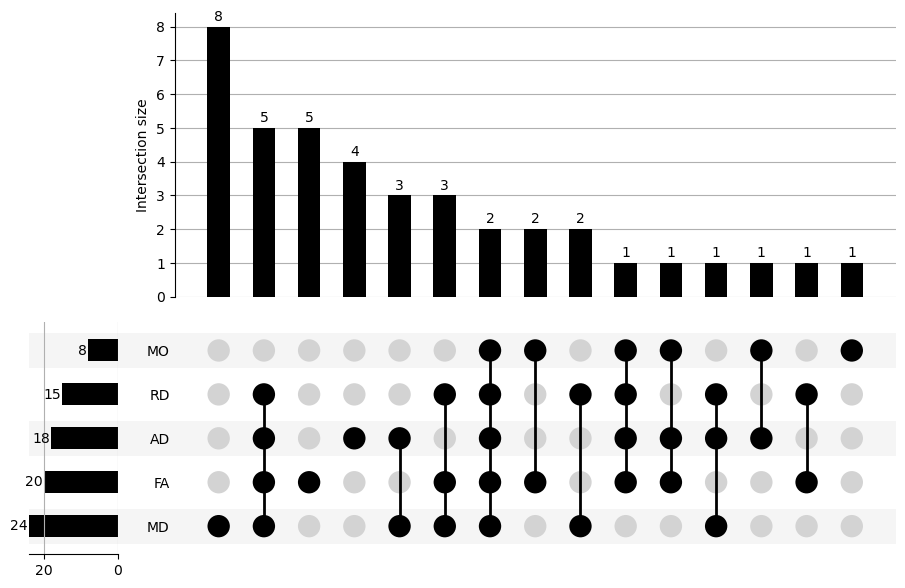

In [71]:
# pattern = 'volume|thickness|surface|[FA|RD|MD|MO|AD|PC\d]: |Net\d+_|Edge|SCZ_PGC3|BIP_PGC3|depression'
# pattern = 'volume|thickness|[FA|RD|MD|MO|AD]: |Node|Edge|SCZ'
# pattern = 'volume|thickness|surface'
pattern = '[FA|RD|MD|MO|AD|PC]:'
# pattern = 'Net'
df_sliced = df_all[(df_all['gwas'].str.contains(pattern))].copy()
df_sliced = df_sliced[df_sliced[f'pvalue_{pval_correction}']<=0.05]
df_sliced = df_sliced.groupby(['gwas','specificity_id','annotation']).size().reset_index().rename(columns={0:'N_methods'})
df_sliced = df_sliced[df_sliced['N_methods']>=2]

# name = 'all'
# name = 'structural'
name = 'DTI'
# name = 'Net'

def create_group(gwas):
    if 'volume' in gwas:
        return 'Structural MRI'
#         return 'Volume'
    elif 'thickness' in gwas:
        return 'Structural MRI'
#         return 'Thickness'
    elif 'surface' in gwas:
        return 'Structural MRI'
#         return 'Surface Area'
    elif bool(re.search('(FA|RD|MD|MO|AD|(PC\d)): ',gwas)):
        return re.findall('DTI (\w+):',gwas)[0]
#         return 'DTI'
    elif bool(re.search('(Net\d+_)|Edge',gwas)):
#         return re.findall('Net\d*_([A-Za-z]+)\d*',gwas)[0]
        return 'rs-fMRI'
    elif 'SCZ' in gwas:
        return 'Schizophrenia'
    elif 'BIP' in gwas:
        return 'Bipolar'
    elif 'depression' in gwas:
        return 'Depression'
 
        
df_sliced['group'] =  df_sliced['gwas'].apply(create_group)
df_sliced_upset = df_sliced.groupby(['specificity_id','annotation'])['group'].agg(list).reset_index()
df_sliced_upset['group'] = df_sliced_upset['group'].apply(set)
df_sliced_upset = df_sliced_upset['group'].value_counts().reset_index()
groups = list(df_sliced['group'].unique())
for g in groups:
    df_sliced_upset[g] = df_sliced_upset['index'].apply(lambda x : g in x)
df_sliced_upset.drop(columns='index', inplace=True)
df_sliced_upset.set_index(groups, inplace=True)
# display(df_sliced_upset)

upset_dir = out_dir + 'upset/'
plt.style.use('default')
upsetplot.plot(df_sliced_upset['group'], show_percentages=False,
               sort_by='cardinality', with_lines=True, #cardinality, degree
               element_size=46, 
               show_counts='%d'
              )
plt.savefig(f"{upset_dir}upsetplot_{name}_groups_significant_annot.png", dpi=200, bbox_inches='tight')
plt.show()

df_sliced = df_sliced.groupby(['specificity_id','annotation'])[['group','gwas']].agg(set).reset_index()
df_sliced['gwas'] = df_sliced['gwas'].apply(lambda x : ', '.join(list(x)))
df_sliced['N_groups'] = df_sliced['group'].apply(len)
df_sliced['group'] = df_sliced['group'].apply(lambda x : ', '.join(list(x)))
df_sliced.sort_values(['N_groups','group'], ascending=[False,True], inplace=True)
df_sliced.drop(columns='N_groups', inplace=True)
df_sliced.to_excel(f"{upset_dir}{name}_groups_significant_annot.xlsx", index=False)

In [281]:
annot_list = df_sliced[['specificity_id','annotation']].drop_duplicates().values.tolist()


ESMU_THRES = 0.0

df_list = []
for dataset, celltype in annot_list:
    cellex_file = f'/home/eerdem/CELLECT-revised/esmu/{dataset}.mu.csv' # change esmu to mu if file not found
    if Path(cellex_file).is_file():
        df_esmu = pd.read_csv(cellex_file, index_col=0)
    elif Path(cellex_file.replace('.mu','.esmu')).is_file():
        df_esmu = pd.read_csv(cellex_file.replace('.mu','.esmu'), index_col=0)
    else:
        print('file not found')
    df = df_esmu[[celltype]].copy()
#     df = df[df[celltype]>ESMU_THRES]
#     display(df)
#     df.columns = [dataset, celltype]
    df.rename(columns={celltype: f"{dataset}, {celltype}"}, inplace=True)
#     display(df)
    df_list.append(df)
    
# import itertools
# from scipy.stats import pearsonr # calculate correlation
# from statsmodels.stats.multitest import multipletests 

# def calculate_pearson(dataframe):
#     corr_list = []
#     pval_list = []
#     gwas_list = dataframe.columns.values
#     for x,y in itertools.combinations(dataframe.columns, 2):
#         corr, pval =  pearsonr(dataframe.loc[:,x].values, dataframe.loc[:,y].values)
#         corr_list.append([x,y,corr])
#         pval_list.append([x,y,pval])
#     corr_list_with_diag = corr_list + [[gwas, gwas, 1] for gwas in gwas_list]
#     pval_list_with_diag = pval_list + [[gwas, gwas, 0] for gwas in gwas_list]
#     corr_df = pd.DataFrame(corr_list_with_diag, columns=['gwasx','gwasy','corr']).pivot(index='gwasx',
#                                                                                         columns='gwasy',
#                                                                                         values='corr')
#     pval_df = pd.DataFrame(pval_list_with_diag, columns=['gwasx','gwasy','pval']).pivot(index='gwasx',
#                                                                                         columns='gwasy',
#                                                                                         values='pval')
#     return corr_df, pval_df

# def correct_pval_correlation(pval_df):
#     '''Uses Bonferroni correction for the input correlation pvalues.'''
#     n = pval_df.shape[0]
#     n_test = (n*(n-1)/2)
#     corrected_pval_df = pval_df * n_test
#     corrected_pval_df[corrected_pval_df > 1] = 1
#     return corrected_pval_df


merged_df = pd.concat(df_list, join='outer', axis=1)
merged_df.sort_index(axis=1, inplace=True)

es_corr_df = calculate_kendalltau(merged_df.fillna(0), with_diag=True)
es_corr = es_corr_df[['gwasx','gwasy','corr']].pivot(columns='gwasx', index='gwasy')
es_pval = es_corr_df[['gwasx','gwasy','pval']].pivot(columns='gwasx', index='gwasy')
sign_pval_df = es_pval < get_pthres(es_corr_df)
sign_pval_df.replace({True:'*', False:''}, inplace=True)

In [901]:
corr_frame.iloc[:,0]

ENSG00000183044    0.200231
ENSG00000115361    0.101718
ENSG00000120437    0.169148
ENSG00000131473    0.164166
ENSG00000068366    0.163012
                     ...   
ENSG00000213967    0.034117
ENSG00000183850    0.478187
ENSG00000102984    0.224179
ENSG00000185869    0.133295
ENSG00000228623    0.064123
Name: Allen_human_LGN, GABAergic.LGN_Inh_CTXN3, Length: 654, dtype: float64

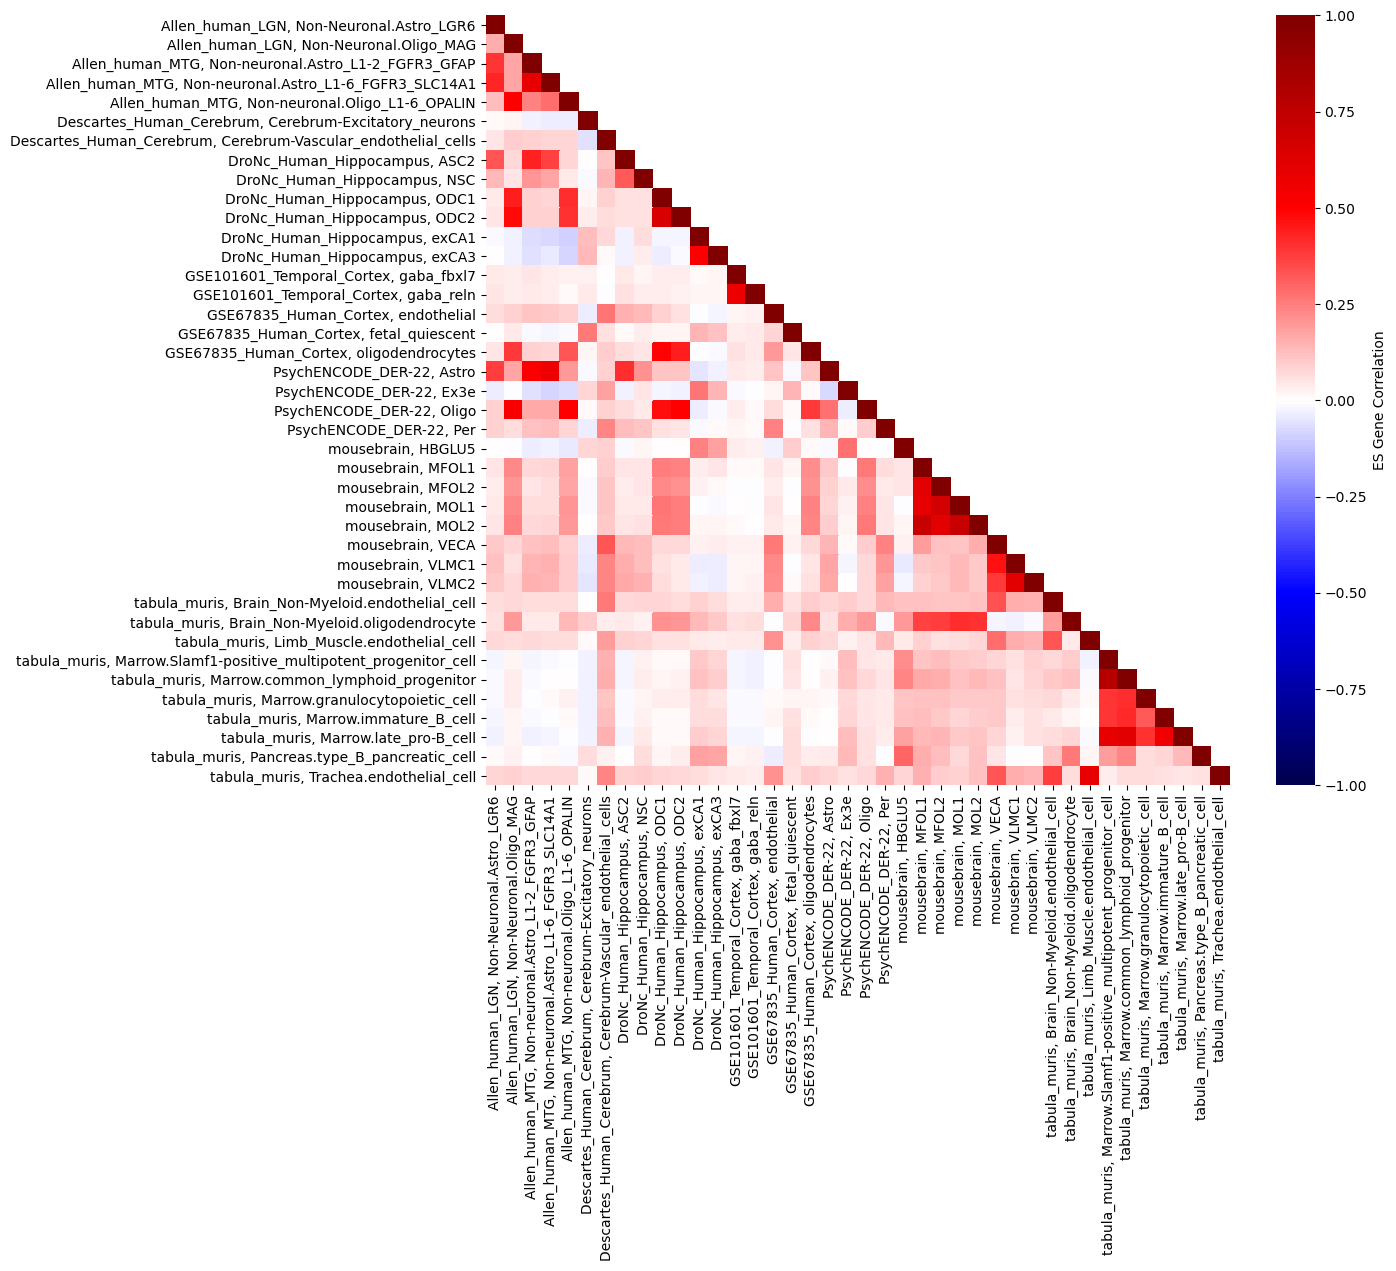

In [284]:
fig, ax = plt.subplots(figsize=(12,10))
g = sns.heatmap(es_corr,
                yticklabels=es_corr.index,
                xticklabels=es_corr.columns.get_level_values(1),
                cmap="seismic",
#                 cmap="jet",
                center=0, cbar_kws={'label': 'ES Gene Correlation'},
                vmin=-1, vmax=1,
#                 annot=sign_pval_df, fmt=''
               )
plt.xlabel('')
plt.ylabel('')
# plt.title(f'Cell-type ES genes correlation\n{name}')
plt.savefig(f"{upset_dir}/{name}_groups_significant_annot_ES_genes_corr.png", dpi=150, bbox_inches='tight')
plt.show()

In [904]:
from scipy.stats import kendalltau # calculate correlation


def calculate_kendalltau(dataframe, with_diag=False):
    corr_list = []
    gwas_list = dataframe.columns.values
    for x,y in itertools.combinations(dataframe.columns, 2):
        corr, pval =  kendalltau(dataframe.loc[:,x].values, dataframe.loc[:,y].values)
        corr_list.append([x,y,corr, pval])
    if with_diag:
        corr_list = corr_list + [[gwas, gwas, 1, 0] for gwas in gwas_list]
    corr_df = pd.DataFrame(corr_list, columns=['gwasx','gwasy','corr','pval'])
    return corr_df

def calculate_es_gene_correlation(dataframe, with_diag=False):
    corr_list = []
    gwas_list = dataframe.columns.values
    for x,y in itertools.combinations(dataframe.columns, 2):
        corr_frame = dataframe.loc[:,[x,y]].fillna(0).copy()
        corr_frame = corr_frame[(corr_frame>0).all(1)]
        corr, pval =  kendalltau(corr_frame.iloc[:,0].values, corr_frame.iloc[:,1].values)
        corr_list.append([x,y,corr, pval])
    if with_diag:
        corr_list = corr_list + [[gwas, gwas, 1, 0] for gwas in gwas_list]
    corr_df = pd.DataFrame(corr_list, columns=['gwasx','gwasy','corr','pval'])
    return corr_df


In [ ]:
annot_list = df_all[['specificity_id','annotation']].drop_duplicates().values.tolist()


# ESMU_THRES = 0.0

df_list = []
for dataset, celltype in annot_list:
    cellex_file = f'/home/eerdem/CELLECT-revised/esmu/{dataset}.mu.csv' # change esmu to mu if file not found
    if Path(cellex_file).is_file():
        df_esmu = pd.read_csv(cellex_file, index_col=0)
    elif Path(cellex_file.replace('.mu','.esmu')).is_file():
        df_esmu = pd.read_csv(cellex_file.replace('.mu','.esmu'), index_col=0)
    else:
        print('file not found')
    df = df_esmu[[celltype]].copy()
#     df = df[df[celltype]>=ESMU_THRES]
#     display(df)
#     df.columns = [dataset, celltype]
    df.rename(columns={celltype: f"{dataset}, {celltype}"}, inplace=True)
#     display(df)
    df_list.append(df)



merged_df = pd.concat(df_list, join='outer', axis=1)
merged_df.sort_index(axis=1, inplace=True)

es_corr_df = calculate_kendalltau(merged_df.fillna(0), with_diag=False)
es_corr_df.to_csv(f'{out_dir}es_corr_df.csv', index=False)

In [905]:
annot_list = df_all[['specificity_id','annotation']].drop_duplicates().values.tolist()


# ESMU_THRES = 0.0

df_list = []
for dataset, celltype in annot_list:
    cellex_file = f'/home/eerdem/CELLECT-revised/esmu/{dataset}.mu.csv' # change esmu to mu if file not found
    if Path(cellex_file).is_file():
        df_esmu = pd.read_csv(cellex_file, index_col=0)
    elif Path(cellex_file.replace('.mu','.esmu')).is_file():
        df_esmu = pd.read_csv(cellex_file.replace('.mu','.esmu'), index_col=0)
    else:
        print('file not found')
    df = df_esmu[[celltype]].copy()
#     df = df[df[celltype]>=ESMU_THRES]
#     display(df)
#     df.columns = [dataset, celltype]
    df.rename(columns={celltype: f"{dataset}, {celltype}"}, inplace=True)
#     display(df)
    df_list.append(df)



merged_df = pd.concat(df_list, join='outer', axis=1)
merged_df.sort_index(axis=1, inplace=True)

es_corr_df = calculate_es_gene_correlation(merged_df.fillna(0), with_diag=False)
es_corr_df.to_csv(f'{out_dir}es_corr_df_no_zerogenes.csv', index=False)

<AxesSubplot:>

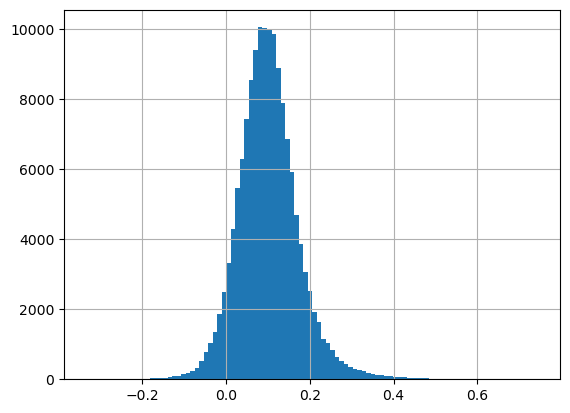

In [907]:
es_corr_df['corr'].hist(bins=100)

In [908]:
es_corr_df.sort_values('corr')

,gwasx,gwasy,corr,pval
61443,"GSE101601_Temporal_Cortex, htrc2","tabula_muris, Lung.classical_monocyte",-0.333333,0.035997
62676,"GSE101601_Temporal_Cortex, zfp804b","tabula_muris, Limb_Muscle.macrophage",-0.323529,0.076169
60660,"GSE101601_Temporal_Cortex, gaba_sst","tabula_muris, Thymus.DN1_thymic_pro-T_cell",-0.320261,0.068497
61463,"GSE101601_Temporal_Cortex, htrc2","tabula_muris, Marrow.granulocytopoietic_cell",-0.319540,0.012904
58918,"GSE101601_Temporal_Cortex, dcc","tabula_muris, Liver.B_cell",-0.314286,0.114247
...,...,...,...,...
94612,"mousebrain, ENTG5","mousebrain, ENTG6",0.670658,0.000000
127534,"mousebrain, PVM1","mousebrain, PVM2",0.684547,0.000000
116614,"mousebrain, MGL1","mousebrain, MGL2",0.690923,0.000000
47223,"Descartes_Human_Cerebellum, Cerebellum-Vascula...","Descartes_Human_Cerebrum, Cerebrum-Vascular_en...",0.719934,0.000000


In [640]:
es_corr_df = pd.read_csv(f'{out_dir}es_corr_df.csv')
es_corr = es_corr_df[['gwasx','gwasy','corr']].pivot(columns='gwasx', index='gwasy')
es_pval = es_corr_df[['gwasx','gwasy','pval']].pivot(columns='gwasx', index='gwasy')
sign_pval_df = es_pval < get_pthres(es_corr_df)
sign_pval_df.replace({True:'*', False:''}, inplace=True)

querying 1-10...done.
Finished.
querying 1-10...done.
Finished.
querying 1-10...done.
Finished.
querying 1-10...done.
Finished.
querying 1-10...done.
Finished.
querying 1-10...done.
Finished.
querying 1-10...done.
Finished.
querying 1-10...done.
Finished.


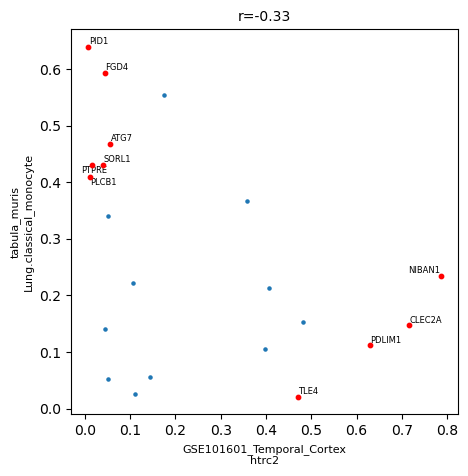

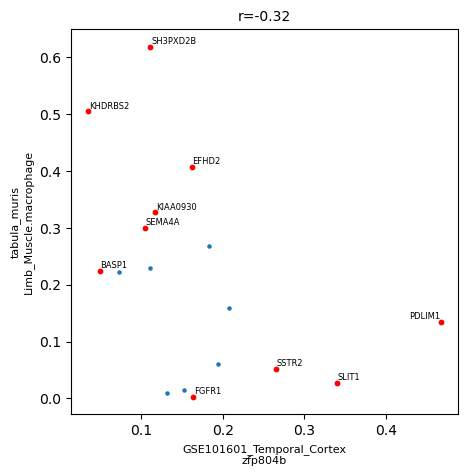

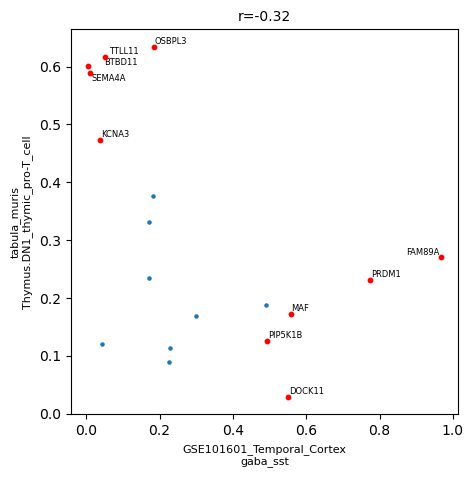

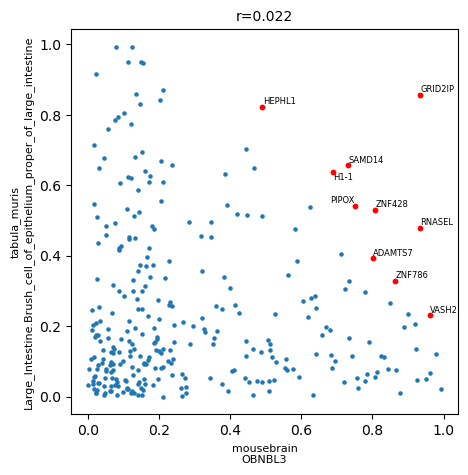

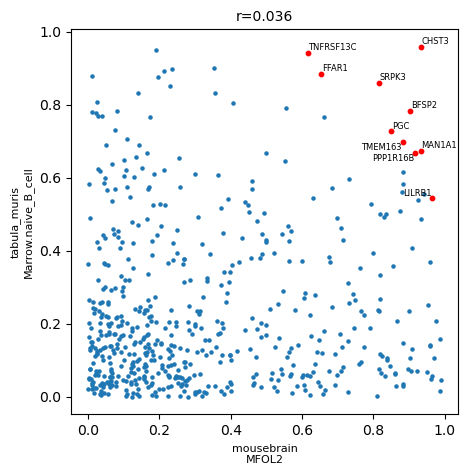

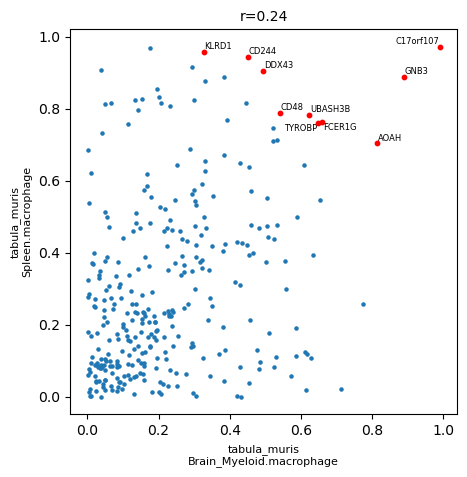

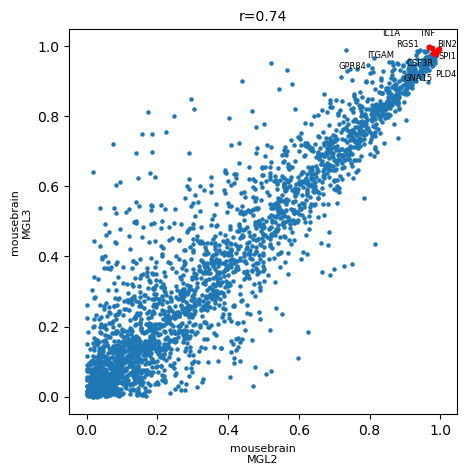

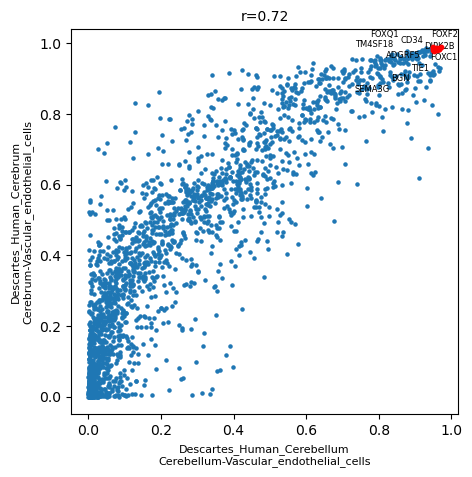

In [910]:
import mygene
N_GENES = 10

gwasxy_slices = es_corr_df.sort_values('corr').iloc[[0,1,2,17000,24000,142498,-1,-2]]
# .iloc[[0,1,2,17000,24000,142498,-1]]

for (index,gwasxy_slice),ax in zip(gwasxy_slices.iterrows(),axes.flatten()):
    fig, ax = plt.subplots(1,1,figsize=(5,5))

    gwasxy_corr_value = gwasxy_slice['corr']
    gwasxy = gwasxy_slice[['gwasx','gwasy']]

    df_list = []
    for gwasx in gwasxy:
        dataset, celltype = gwasx.split(', ')
    #     print(dataset, celltype)
        cellex_file = f'/home/eerdem/CELLECT-revised/esmu/{dataset}.mu.csv' # change esmu to mu if file not found
        if Path(cellex_file).is_file():
            df_esmu = pd.read_csv(cellex_file, index_col=0)
        elif Path(cellex_file.replace('.mu','.esmu')).is_file():
            df_esmu = pd.read_csv(cellex_file.replace('.mu','.esmu'), index_col=0)
        else:
            print('file not found')
        df = df_esmu[[celltype]].copy()
        df.rename(columns={celltype: f"{dataset}, {celltype}"}, inplace=True)
        df_list.append(df)
    df_esmu = pd.concat(df_list, join='outer', axis=1).fillna(0)
    df_esmu.sort_index(axis=1, inplace=True)
    df_esmu = df_esmu[(df_esmu>0).all(1)]
    ax.scatter(df_esmu[f'{gwasxy[0]}'],df_esmu[f'{gwasxy[1]}'],s=5)
    ax.set_xlabel(gwasxy[0].replace(', ','\n'),size=8)
    ax.set_ylabel(gwasxy[1].replace(', ','\n'),size=8)
    ax.set_title(f'r={gwasxy_corr_value:.2}', size=10)
    if gwasxy_corr_value > 0:
        top_gene_list = (df_esmu.assign(m=lambda x : x.mean(1)).sort_values('m').iloc[-N_GENES:].index.tolist())
    else:        
        top_gene_list = (df_esmu.diff(axis=1).abs().sort_values(gwasxy[-1]).iloc[-N_GENES:].index.tolist())
        
            
    mg = mygene.MyGeneInfo()
    genes = []
    for g in mg.querymany(top_gene_list, scopes='ensembl.gene'):
        if 'symbol' in g.keys():
            genes.append(g['symbol']) 
        else:
            genes.append('')
    adjust_text([ax.annotate(g,(x,y),color='k', fontsize=6) 
                 for g,(__,(x,y)) in zip(genes,df_esmu.loc[top_gene_list].iterrows())],
#                 arrowprops=dict(arrowstyle='-', color='black')
               )
    
    for g,(__,(x,y)) in zip(genes,df_esmu.loc[top_gene_list].iterrows()):
        ax.scatter(x,y,s=10, color='red', zorder=9)
#     ax.legend()

    
    
    val = round(gwasxy_corr_value,1)
    if val == -0.0:
        val = 0.0    
    plt.savefig(f"{out_dir}es_corr_scatterplots_no_zerogenes/{val}_-_{'_-_'.join(gwasxy.values).replace(', ','-')}.png",
                dpi=200, bbox_inches='tight')
# plt.show()

In [815]:
df_esmu.loc[top_gene_list]

,"Allen_human_MTG, Non-neuronal.Micro_L1-3_TYROBP","Descartes_Human_Cerebrum, Cerebrum-Limbic_system_neurons"
ENSG00000273451,NaN,0.163076
ENSG00000273472,NaN,0.176543
ENSG00000273486,NaN,0.000000
ENSG00000273489,NaN,0.000000
ENSG00000273492,NaN,0.521899


In [801]:
df_esmu.diff(axis=1).abs().sort_values(gwasxy[-1])

,"mousebrain, MGL2","mousebrain, MGL3"
gene,,
ENSG00000141668,NaN,0.000000
ENSG00000242715,NaN,0.000000
ENSG00000140044,NaN,0.000000
ENSG00000178187,NaN,0.000000
ENSG00000100490,NaN,0.000000
...,...,...
ENSG00000173391,NaN,0.732413
ENSG00000186529,NaN,0.773508
ENSG00000124449,NaN,0.814077


'mousebrain-MGL2_-_mousebrain-MGL3'

'out/es_corr_scatterplots'

In [744]:
display(top_gene_list)


['ENSG00000165659',
 'ENSG00000112562',
 'ENSG00000170485',
 'ENSG00000102024',
 'ENSG00000106852']

0.5355059668720776
0.8380263371930479
0.607498635488694
0.6740457379388038
0.8634018882293535


In [307]:
cellex_file = f'/home/eerdem/CELLECT-revised/esmu/Descartes_Human_Cerebrum.mu.csv' # change esmu to mu if file not found
if Path(cellex_file).is_file():
    df_esmu = pd.read_csv(cellex_file, index_col=0)
elif Path(cellex_file.replace('.mu','.esmu')).is_file():
    df_esmu = pd.read_csv(cellex_file.replace('.mu','.esmu'), index_col=0)
else:
    print('file not found')

In [318]:
df_esmu

,Cerebrum-Astrocytes,Cerebrum-Excitatory_neurons,Cerebrum-Inhibitory_neurons,Cerebrum-Limbic_system_neurons,Cerebrum-Megakaryocytes,Cerebrum-Microglia,Cerebrum-Oligodendrocytes,Cerebrum-SKOR2_NPSR1_positive_cells,Cerebrum-Vascular_endothelial_cells
gene,,,,,,,,,
ENSG00000000003,0.527268,0.000000,0.000000,0.000000,0.000000,0.000000,0.070555,0.000000,0.515041
ENSG00000000460,0.000000,0.000000,0.000000,0.000000,0.000000,0.569174,0.000000,0.000000,0.000000
ENSG00000000938,0.000000,0.000000,0.000000,0.000000,0.000000,0.014206,0.000000,0.000000,0.878818
ENSG00000000971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.960629
ENSG00000001036,0.000000,0.000000,0.000000,0.009923,0.000000,0.503031,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
ENSG00000273451,0.000000,0.000000,0.066772,0.163076,0.000000,0.000000,0.139792,0.138385,0.000000
ENSG00000273472,0.000000,0.000000,0.000000,0.176543,0.635529,0.033820,0.000000,0.010216,0.000000
ENSG00000273486,0.000000,0.000000,0.000000,0.000000,0.177543,0.448085,0.000000,0.000000,0.000000


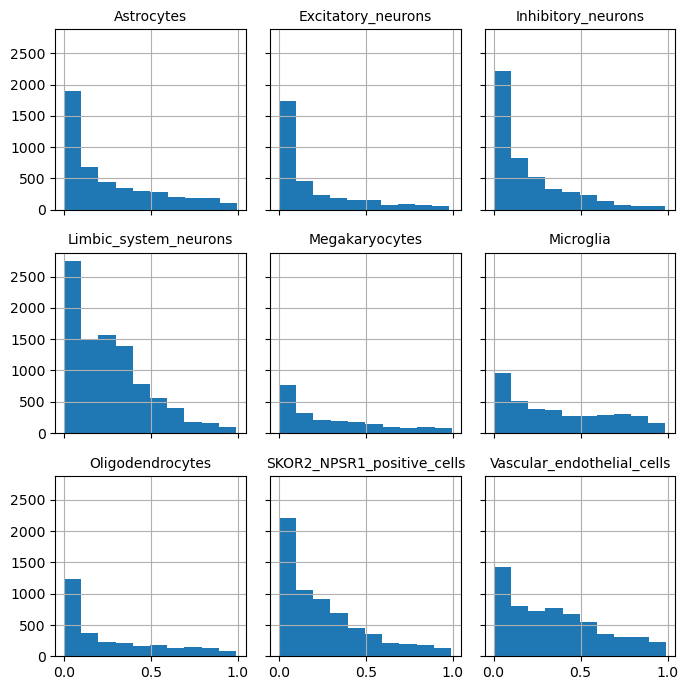

In [317]:
fig, axes = plt.subplots(3,3,figsize=(7,7), sharex=True, sharey=True)
for ax,(ct, row) in zip(axes.flatten(),df_esmu.T.iterrows()):
    ax.hist(row,bins=10)
    ax.set_title(ct.split('-')[-1],size=10)
    ax.grid()
# plt.hist(df_esmu,bins=10)
# plt.title('ES ditribution')
# plt.grid()
plt.tight_layout()
plt.show()

In [287]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
df_esmu

,ASC1,ASC2,END,GABA1,GABA2,MG,NSC,ODC1,ODC2,OPC,exCA1,exCA3,exDG,exPFC1,exPFC2
gene,,,,,,,,,,,,,,,
ENSG00000268895,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.050963,0.0,0.015238,0.125513,0.000000,0.354698,0.000000
ENSG00000175899,0.000000,0.000000,0.798519,0.000000,0.000000,0.57891,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000166535,0.884156,0.722656,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000128274,0.012620,0.000000,0.889029,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000094914,0.011776,0.000000,0.000000,0.000000,0.000000,0.00000,0.269709,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.047000,0.334751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000153975,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.354246,0.000000,0.000000,0.000000,0.247950
ENSG00000122952,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.792194,0.677215,0.000000,0.118185,0.000000
ENSG00000162378,0.000000,0.000000,0.000000,0.332288,0.398926,0.00000,0.000000,0.0,0.000000,0.0,0.105593,0.000000,0.211740,0.283113,0.285233


In [194]:
df = es_corr_df.copy()
df['gwasx'] = df['gwasx'].str.split(',').str[0]
df['gwasy'] = df['gwasy'].str.split(',').str[0]
df['gwas'] = df['gwasx'] +'--'+ df['gwasy']
df['corr'] = df['corr'].round(1)
df = df.groupby('corr')['gwas'].agg(list).to_frame()

In [195]:
from collections import Counter
corr_dict = {}
for corr, row in df.iterrows():
    corr_dict[corr] = Counter(row.to_list()[0])
    print(corr)
    print(corr_dict[corr])
#     break
# df.iloc[0].to_list()[0]

-0.2
Counter({'Descartes_Human_Cerebrum--Descartes_Human_Cerebrum': 1})
-0.1
Counter({'mousebrain--mousebrain': 540, 'Allen_human_MTG--mousebrain': 192, 'Descartes_Human_Cerebrum--mousebrain': 75, 'PsychENCODE_DER-22--mousebrain': 50, 'Allen_human_MTG--PsychENCODE_DER-22': 32, 'Allen_human_MTG--DroNc_Human_Hippocampus': 29, 'Allen_human_MTG--Descartes_Human_Cerebrum': 19, 'Descartes_Human_Cerebrum--tabula_muris': 17, 'mousebrain--tabula_muris': 15, 'Allen_human_LGN--mousebrain': 11, 'Descartes_Human_Cerebrum--PsychENCODE_DER-22': 10, 'Allen_human_MTG--Allen_human_MTG': 9, 'DroNc_Human_Hippocampus--PsychENCODE_DER-22': 9, 'Descartes_Human_Cerebrum--DroNc_Human_Hippocampus': 7, 'Descartes_Human_Cerebrum--GSE67835_Human_Cortex': 6, 'tabula_muris--tabula_muris': 6, 'Allen_human_LGN--Descartes_Human_Cerebrum': 5, 'Allen_human_LGN--tabula_muris': 5, 'PsychENCODE_DER-22--PsychENCODE_DER-22': 5, 'Descartes_Human_Cerebrum--Descartes_Human_Cerebrum': 4, 'Allen_human_LGN--Allen_human_MTG': 3, 'Al

In [199]:
marrow_corr_df = es_corr_df[es_corr_df['gwasx'].str.contains('Marrow')|es_corr_df['gwasy'].str.contains('Marrow')]
marrow_corr_df
# marrow_corr_df < get_pthres(marrow_corr_df)

,gwasx,gwasy,corr,pval
496,"Allen_human_LGN, GABAergic.LGN_Inh_CTXN3","tabula_muris, Marrow.B_cell",0.029028,9.594558e-07
497,"Allen_human_LGN, GABAergic.LGN_Inh_CTXN3","tabula_muris, Marrow.Slamf1-negative_multipote...",0.020330,3.706928e-04
498,"Allen_human_LGN, GABAergic.LGN_Inh_CTXN3","tabula_muris, Marrow.Slamf1-positive_multipote...",0.017737,1.989085e-03
499,"Allen_human_LGN, GABAergic.LGN_Inh_CTXN3","tabula_muris, Marrow.basophil",0.014702,1.325349e-02
500,"Allen_human_LGN, GABAergic.LGN_Inh_CTXN3","tabula_muris, Marrow.common_lymphoid_progenitor",0.026746,2.614679e-06
...,...,...,...,...
147910,"tabula_muris, Marrow.regulatory_T_cell","tabula_muris, Tongue.keratinocyte",0.053293,9.191231e-20
147911,"tabula_muris, Marrow.regulatory_T_cell","tabula_muris, Trachea.blood_cell",0.242184,0.000000e+00
147912,"tabula_muris, Marrow.regulatory_T_cell","tabula_muris, Trachea.endothelial_cell",0.049986,8.497151e-17
147913,"tabula_muris, Marrow.regulatory_T_cell","tabula_muris, Trachea.epithelial_cell",-0.002313,6.998383e-01


In [207]:
es_corr_df[(es_corr_df['gwasx'].str.contains('tabula'))&(es_corr_df['gwasy'].str.contains('tabula'))]

,gwasx,gwasy,corr,pval
141685,"tabula_muris, Bladder.bladder_cell","tabula_muris, Bladder.bladder_urothelial_cell",0.224000,0.000000e+00
141686,"tabula_muris, Bladder.bladder_cell","tabula_muris, Brain_Myeloid.macrophage",0.027076,3.842653e-06
141687,"tabula_muris, Bladder.bladder_cell","tabula_muris, Brain_Myeloid.microglial_cell",0.074200,1.431966e-37
141688,"tabula_muris, Bladder.bladder_cell","tabula_muris, Brain_Non-Myeloid.Bergmann_glial...",0.164534,3.587978e-175
141689,"tabula_muris, Bladder.bladder_cell","tabula_muris, Brain_Non-Myeloid.astrocyte",0.187499,1.339655e-232
...,...,...,...,...
148235,"tabula_muris, Trachea.blood_cell","tabula_muris, Trachea.epithelial_cell",0.034696,4.144946e-09
148236,"tabula_muris, Trachea.blood_cell","tabula_muris, Trachea.mesenchymal_cell",0.119073,4.912139e-94
148237,"tabula_muris, Trachea.endothelial_cell","tabula_muris, Trachea.epithelial_cell",0.112159,3.790463e-80
148238,"tabula_muris, Trachea.endothelial_cell","tabula_muris, Trachea.mesenchymal_cell",0.310245,0.000000e+00


<AxesSubplot:>

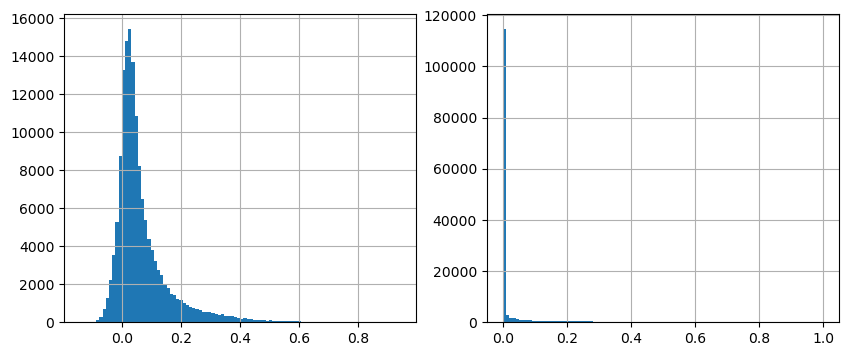

In [125]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
es_corr_df['corr'].hist(bins=100, ax=ax[0])
es_corr_df['pval'].hist(bins=100, ax=ax[1])

Text(0.5, 0.98, 'Kendall Tau')

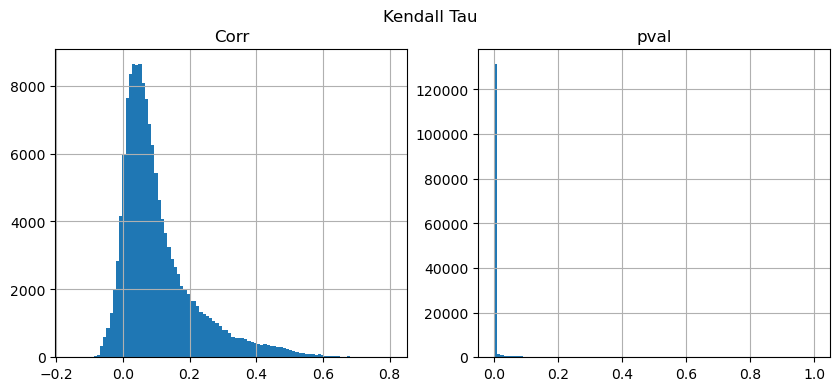

In [264]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
es_corr_df['corr'].hist(bins=100, ax=ax[0])
es_corr_df['pval'].hist(bins=100, ax=ax[1])
ax[0].set_title('Corr')
ax[1].set_title('pval')
plt.suptitle('Kendall Tau')

In [627]:
es_corr_df.sort_values('corr')

,gwasx,gwasy,corr,pval
156,"Allen_human_MTG, Non-neuronal.Oligo_L1-6_OPALIN","DroNc_Human_Hippocampus, exCA1",-0.088657,3.770788e-54
157,"Allen_human_MTG, Non-neuronal.Oligo_L1-6_OPALIN","DroNc_Human_Hippocampus, exCA3",-0.085111,7.825102e-49
129,"Allen_human_MTG, Non-neuronal.Astro_L1-6_FGFR3...","PsychENCODE_DER-22, Ex3e",-0.084820,1.038709e-49
549,"PsychENCODE_DER-22, Astro","PsychENCODE_DER-22, Ex3e",-0.074894,1.313347e-38
121,"Allen_human_MTG, Non-neuronal.Astro_L1-6_FGFR3...","DroNc_Human_Hippocampus, exCA1",-0.071538,2.956998e-36
...,...,...,...,...
793,"GSE101601_Temporal_Cortex, gaba_fbxl7","GSE101601_Temporal_Cortex, gaba_fbxl7",1.000000,0.000000e+00
794,"GSE101601_Temporal_Cortex, gaba_reln","GSE101601_Temporal_Cortex, gaba_reln",1.000000,0.000000e+00
795,"GSE67835_Human_Cortex, endothelial","GSE67835_Human_Cortex, endothelial",1.000000,0.000000e+00
798,"PsychENCODE_DER-22, Astro","PsychENCODE_DER-22, Astro",1.000000,0.000000e+00


In [624]:
es_corr_df.sort_values('corr', ascending=False).to_excel('ES_corr.xlsx',index=False )

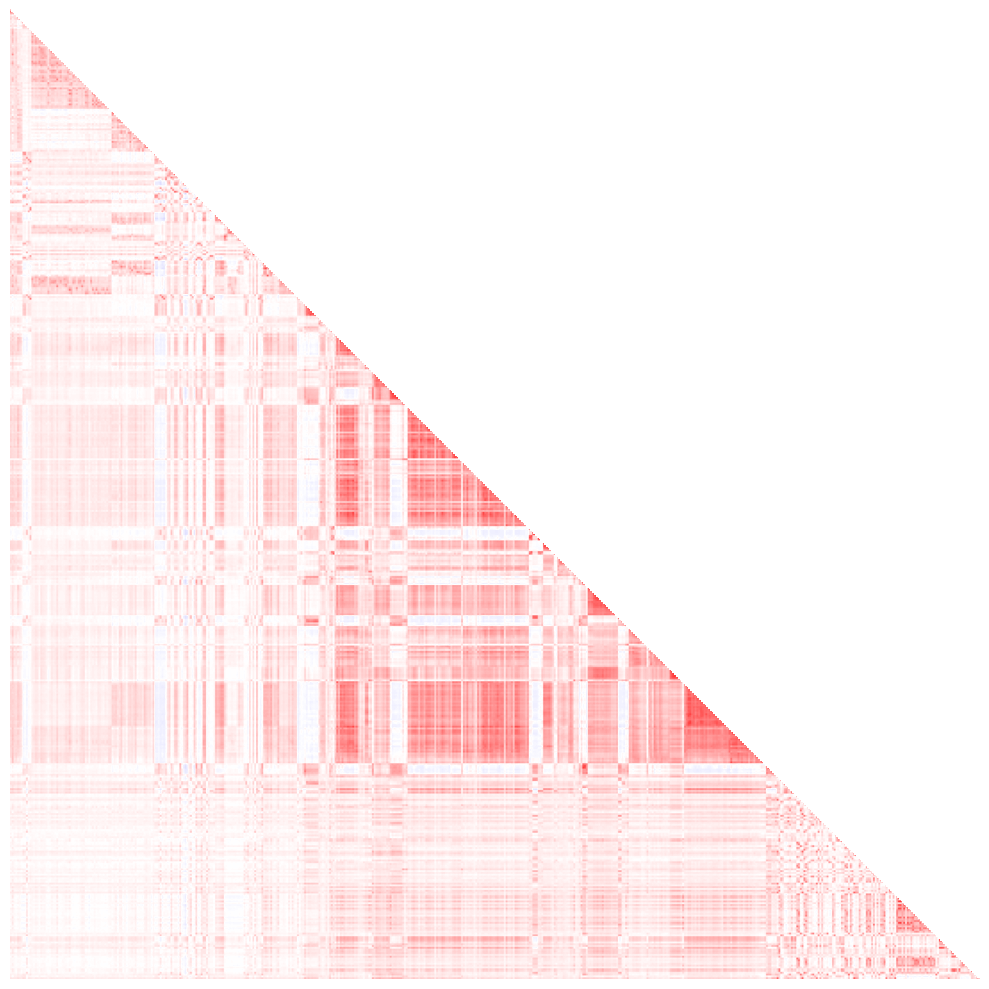

In [196]:
fig, ax = plt.subplots(figsize=(10,10)) 

ax.imshow(es_corr, cmap='bwr', vmin=-1, vmax=1)
ax.set_axis_off()
plt.tight_layout()

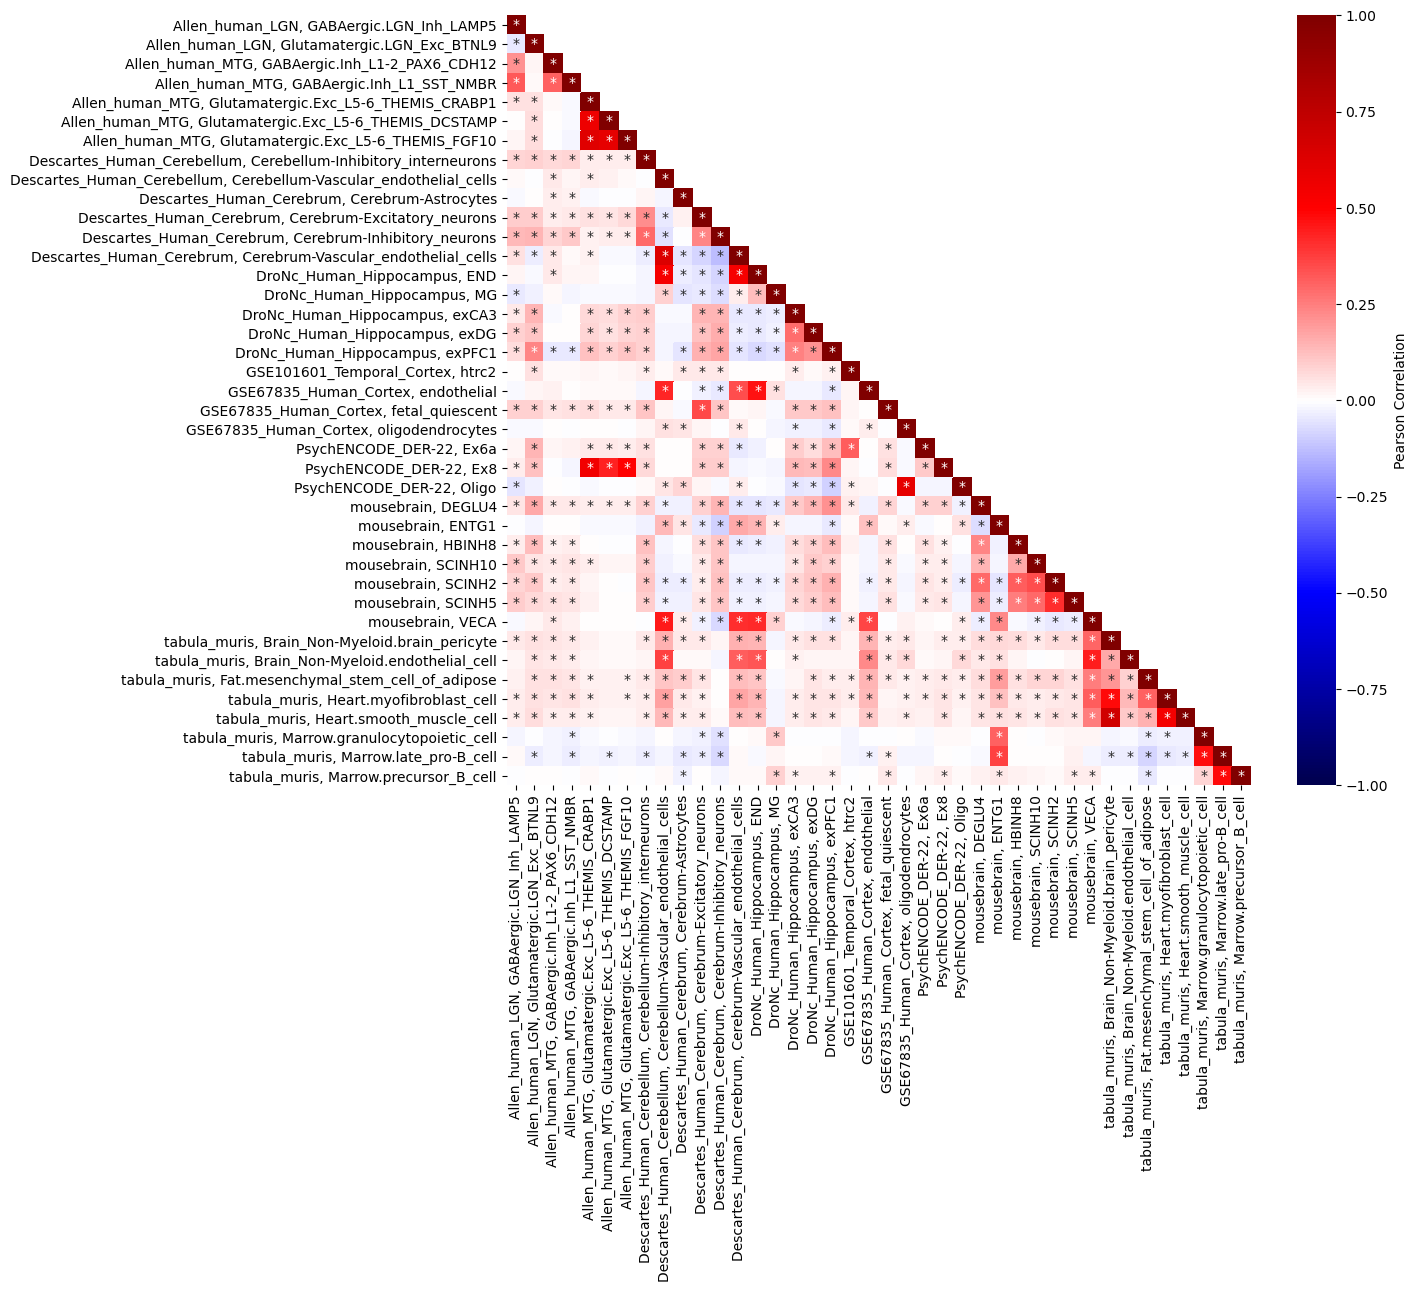

In [50]:
# fig, ax = plt.subplots(figsize=(12,10))
# g = sns.heatmap(corr_df.T,
#                 yticklabels=corr_df.columns,
#                 xticklabels=corr_df.columns,
#                 cmap="seismic",
# #                     cmap="jet",
#                 center=0, cbar_kws={'label': 'Pearson Correlation'},
#                 vmin=-1, vmax=1,
#                 annot=sign_pval_df.T, fmt=''
#                )
# plt.xlabel('')
# plt.ylabel('')
# # plt.title(f'Cell-type ES genes correlation\n{name}')
# plt.savefig(f"{upset_dir}/{name}_groups_significant_annot_ES_genes_corr.png", dpi=150, bbox_inches='tight')
# plt.show()

In [103]:
# # import os 
# # import sys
# import math
# import collections
# import numpy as np
# import matplotlib
# # matplotlib.use("Agg")
# import matplotlib.pyplot as plt
# import matplotlib.path    as mpath
# import matplotlib.patches as mpatches

# class Gcircle(object):
#     colors = ["#4E79A7","#F2BE2B","#E15759","#76B7B2","#59A14F","#EDC948","#B07AA1","#FF9DA7","#9C755F","#BAB0AC"]
#     cmaps  = [plt.cm.Reds, plt.cm.Blues, plt.cm.Greens, plt.cm.Greys]  
#     def __init__(self):
#         self.locus_dict = collections.OrderedDict() 
#         self.interspace = np.pi / 60 
#         self.bottom      = 500 
#         self.height      = 50 
#         self.facecolor   = "#DDDDDD"
#         self.edgecolor   = "#000000"
#         self.linewidth   = 1.0 
#         self.markersize  = 2.0 
#         self.color_cycle = 0 
#         self.cmap_cycle  = 0

#     def add_locus(self, name, length, bottom=None, height=None, facecolor=None, edgecolor=None, linewidth=None, interspace=None):
#         self.locus_dict[name]                 = {}
#         self.locus_dict[name]["length"]       = length
#         self.locus_dict[name]["features"] = [] 
        
#         if bottom is None:
#             self.locus_dict[name]["bottom"] = self.bottom
#         else:
#             self.locus_dict[name]["bottom"] = bottom
        
#         if height is None:
#             self.locus_dict[name]["height"] = self.height 
#         else:
#             self.locus_dict[name]["height"] = height

#         if facecolor is None: 
#             self.locus_dict[name]["facecolor"] = self.facecolor 
#         else:
#             self.locus_dict[name]["facecolor"] = facecolor

#         if edgecolor is None:
#             self.locus_dict[name]["edgecolor"] = self.edgecolor
#         else:
#             self.locus_dict[name]["edgecolor"] = edgecolor

#         if interspace is None:
#             self.locus_dict[name]["linewidth"] = self.linewidth
#         else:
#             self.locus_dict[name]["linewidth"] = linewidth

#         if interspace is None:
#             self.locus_dict[name]["interspace"] = self.interspace
#         else:
#             self.locus_dict[name]["interspace"] = interspace 


#         sum_length       = sum(list(map(lambda x:  self.locus_dict[x]["length"], list(self.locus_dict.keys()))))
#         sum_interspace   = sum(list(map(lambda x:  self.locus_dict[x]["interspace"], list(self.locus_dict.keys()))))
#         self.theta_list  = np.linspace(0.0, 2 * np.pi - sum_interspace, sum_length, endpoint=True)
#         s = 0
#         sum_interspace = 0 
#         for key in self.locus_dict.keys():
#             self.locus_dict[key]["positions"] = sum_interspace + self.theta_list[s:s+self.locus_dict[key]["length"]+1]
#             if s+self.locus_dict[key]["length"]+1 > len(self.theta_list):
#                 self.locus_dict[key]["positions"] = self.locus_dict[key]["positions"] + self.theta_list[:s+self.locus_dict[key]["length"] + 1- len(self.theta_list)]
#             s = s + self.locus_dict[key]["length"]
#             sum_interspace += self.locus_dict[key]["interspace"]
            
#     def ax(self):
#         'added function'
#         return self.ax 
    
#     def node_group_position(self):
#         'added function'
#         pos_dict = {}
#         for k,v in self.locus_dict.items():
#             cluster = k.split(',')[0] # splitting with , only works because of how the nodes were named
#             pos = v['positions']
#             if cluster not in pos_dict.keys():
#                 pos_dict[cluster] = [pos]
#             else:
#                  pos_dict[cluster].append(pos)
#         return {k: [min([y for x in v for y in x]), max([y for x in v for y in x])] for k,v in pos_dict.items()}
    
#     def set_locus(self, figsize=(6, 6), lw=1): 
#         self.figure = plt.figure(figsize=figsize)
#         self.ax     = plt.subplot(111, polar=True)
#         self.ax.set_theta_zero_location("N")
#         self.ax.set_theta_direction(-1)
#         self.ax.set_ylim(0,1000)
#         self.ax.spines['polar'].set_visible(False)
#         self.ax.xaxis.set_ticks([])
#         self.ax.xaxis.set_ticklabels([])
#         self.ax.yaxis.set_ticks([])
#         self.ax.yaxis.set_ticklabels([])  
                
#         pre_e = 0 
#         for i, key in enumerate(self.locus_dict.keys()):
#             pos       = self.locus_dict[key]["positions"][0] 
#             width     = self.locus_dict[key]["positions"][-1] - self.locus_dict[key]["positions"][0]
#             height    = self.locus_dict[key]["height"]
#             bottom    = self.locus_dict[key]["bottom"]
#             facecolor = self.locus_dict[key]["facecolor"]
#             edgecolor = self.locus_dict[key]["edgecolor"]
#             linewidth = self.locus_dict[key]["linewidth"]
#             self.locus_dict[key]["bar"] = self.ax.bar([pos], [height], bottom=bottom, width=width, facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, align="edge")
    
#     def chord_plot(self, start_list, end_list,  bottom=500, center=0, color="#1F77B4", alpha=0.5):
#         #start_list and end_list is composed of "locus_id", "start", "end". 
#         sstart = self.locus_dict[start_list[0]]["positions"][start_list[1]]
#         send   = self.locus_dict[start_list[0]]["positions"][start_list[2]+1]   
#         if len(start_list) == 4:
#             stop = int(start_list[3]) 
#         else:
#             stop = bottom

#         ostart = self.locus_dict[end_list[0]]["positions"][end_list[1]]
#         oend   = self.locus_dict[end_list[0]]["positions"][end_list[2]+1] 
#         if len(end_list) == 4:
#             etop = int(end_list[3]) 
#         else:
#             etop = bottom

#         z1 = stop - stop * math.cos(abs((send-sstart) * 0.5)) 
#         z2 = etop - etop * math.cos(abs((oend-ostart) * 0.5)) 
#         if sstart == ostart: 
#             pass 
#         else:
#             Path      = mpath.Path
#             path_data = [(Path.MOVETO,  (sstart, stop)),
#                          (Path.CURVE3,  (sstart, center)),     
#                          (Path.CURVE3,  (oend,   etop)),
#                          (Path.CURVE3,  ((ostart+oend)*0.5, etop+z2)),
#                          (Path.CURVE3,  (ostart, etop)),
#                          (Path.CURVE3,  (ostart, center)),
#                          (Path.CURVE3,  (send,   stop)),
#                          (Path.CURVE3,  ((sstart+send)*0.5, stop+z1)),
#                          (Path.CURVE3,  (sstart, stop)),
#                         ]
#             codes, verts = list(zip(*path_data)) 
#             path  = mpath.Path(verts, codes)
#             patch = mpatches.PathPatch(path, facecolor=color, alpha=alpha, linewidth=0, zorder=0)
#             self.ax.add_patch(patch)
 


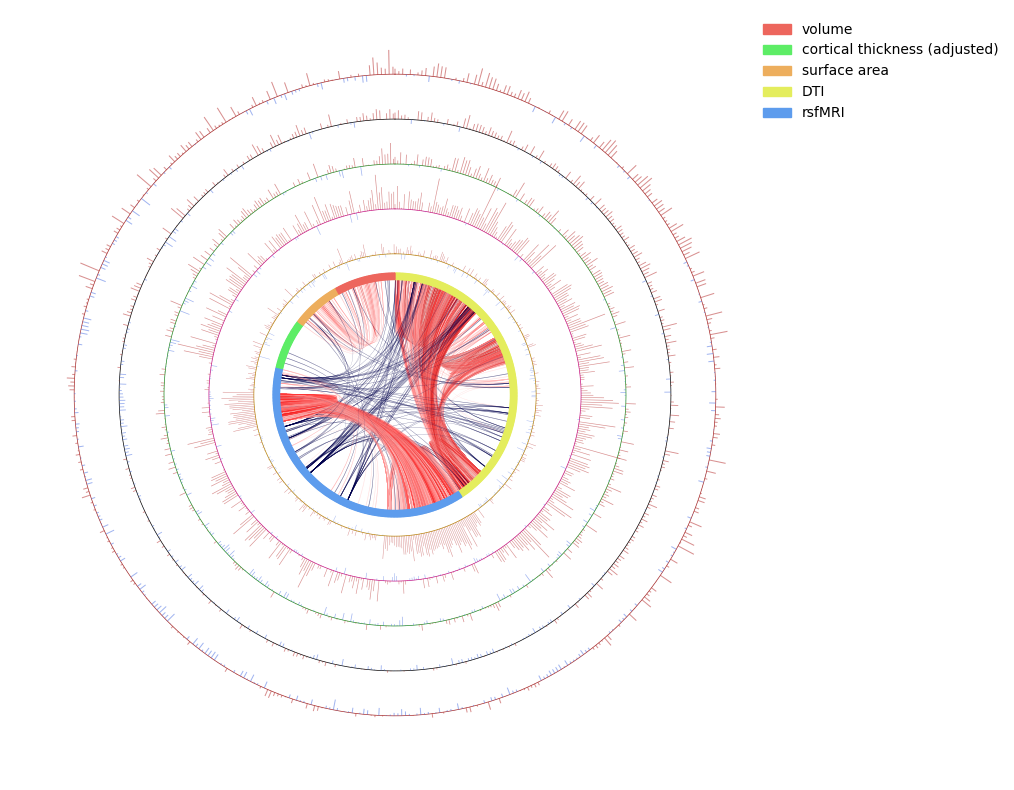

In [200]:
# from matplotlib import cm
# import matplotlib.patches as mpatches

    
# def bluered_cmap(array):
#     cmap = []
#     for i in array:
#         if i<=0:
#             c = 'royalblue'
#         else:
#             c = 'firebrick'
#         cmap.append(c)
#     return cmap

# def chord_plot_pandas(gcircle, row, corr_limit):
#     if (row['corr']>=corr_limit[0] or row['corr']<=corr_limit[1]) and row['pval_bonferroni']<=0.05:
#         nodes = []
#         for i in [1,2]:
#             node = row[f"gwas{i}"]
#             if 'volume' in node:
#                 node = f"volume, {node}"
#             elif 'thickness' in node:
#                 node = f"thickness, {node}"
#             elif 'surface' in node:
#                 node = f"area, {node}"
#             elif bool(re.search('(FA|RD|MD|MO|AD|(PC\d)): ',node)):
#                 node = f"DTI, {node}"
#             elif bool(re.search('(Net\d+_)|Edge',node)):
#                 node = f"rsFMRI, {node}"
#             nodes.append(node)
#         gcircle.chord_plot([nodes[0],0,0,900],[nodes[1],0,0,900],color=cmap(norm(row['corr'])),alpha=.3)

# def annotation_layer(df, nodes, method, specificity_id, annotation, bottom=1100, axis_color='k'):
#     step = 0.001
#     theta = np.linspace(0,(2-(2*step))*np.pi, len(nodes))
#     scale = {'H-MAGMA':500,
#                 'LDSC':20e8,
#                'MAGMA':500}
#     # alligns the plot correctly to the group
#     node_group1 = gcircle.node_group_position()[next(iter(gcircle.node_group_position()))] #get position of first nodegroup
#     theta = np.concatenate((theta[sum(theta < node_group1[1]):], theta[:sum(theta < node_group1[1])])) #adjust theta start and end
#     beta_annot = df[
#         (df.method==m)
#         &
#         (df.gwas.isin(nodes))
#         &
#         (df.specificity_id==specificity_id)
#         &
#         (df.annotation==annotation)
#     ]['beta'] * scale[method] #scales beta values so its visible
    
#     gcircle.ax.bar(theta, beta_annot, color=bluered_cmap(beta_annot),
# #                    edgecolor=axis_color,
#                    alpha=.5, width=step*np.pi, bottom=bottom, zorder=9)
#     x = np.linspace(0,2*np.pi, len(nodes))
#     y = [bottom]*len(x)
#     gcircle.ax.plot(x, y, alpha=1,
#                     color=axis_color,
#                     lw=.5, zorder=8)


# m = 'LDSC'
# plt.style.use('default')
# cmap = cm.get_cmap('seismic')
# norm = plt.Normalize(-1, 1)

# corr_df = corr_pears_methods_dict[m]
# # corr_df = corr_df.iloc[422:,422:]
# # corr_df = corr_df.iloc[466:,466:]
# corr_df.rename_axis(None)
# corr_df.columns.names = [None]

# links = corr_df.stack().reset_index()
# links.columns = ['gwas1', 'gwas2','corr']
# links = links[
#     links[['gwas1','gwas2']].apply(lambda x:
#                                    x.str.contains('volume|thickness|surface|[FA|RD|MD|MO|AD|PC\d]: |Net\d+_|Edge'))\
#     .all(axis=1)]
# pval_df = pval_pears_methods_dict[m]
# pval_corrected_df = correct_pval_correlation(pval_df) # Bonferroni
# pval_corrected_df.rename_axis(None)
# pval_corrected_df.columns.names = [None]
# plinks = pval_corrected_df.stack().reset_index()
# plinks.columns = ['gwas1', 'gwas2','pval_bonferroni']

# links = links.merge(plinks, on=['gwas1','gwas2'] )
# nodes = links.gwas1.unique()
# # links[['gwas1','gwas2']] = links[['gwas1','gwas2']].applymap(rename_node)
# # links.sort_values(by='gwas1', inplace=True)

# # make nodes
# gcircle = Gcircle()
# for node in nodes:
#     if 'volume' in node:
#         gcircle.add_locus(f"volume, {node}", 2, bottom=900, linewidth=1, interspace=0, facecolor="#ED665D", edgecolor="#ED665D")
#     elif 'thickness' in node:
#         gcircle.add_locus(f"thickness, {node}", 2, bottom=900, linewidth=1, interspace=0, facecolor="#5DED66", edgecolor="#5DED66")
#     elif 'surface' in node:
#         gcircle.add_locus(f"area, {node}", 2, bottom=900, linewidth=1, interspace=0, facecolor="#EDAE5D", edgecolor="#EDAE5D")
#     elif bool(re.search('(FA|RD|MD|MO|AD|(PC\d)): ',node)):
#         gcircle.add_locus(f"DTI, {node}", 2, bottom=900, linewidth=1, interspace=0, facecolor="#E4ED5D", edgecolor="#E4ED5D")
#     elif bool(re.search('(Net\d+_)|Edge',node)):
#         gcircle.add_locus(f"rsFMRI, {node}", 2, bottom=900, linewidth=1, interspace=0, facecolor="#5D9CED", edgecolor="#5D9CED")
# gcircle.set_locus(figsize=(10, 10)) #Creat figure object

# # make edges
# corr_limit = (links[(links['corr']>0)&(links['pval_bonferroni']<=0.05)]['corr'].quantile(.85),
#              links[(links['corr']<0)&(links['pval_bonferroni']<=0.05)]['corr'].quantile(.15))        
# links.apply(lambda row: chord_plot_pandas(gcircle, row, corr_limit), axis=1)

# gcircle.ax.set_ylim(0,3000)
# # gcircle.ax.set_xlim(0,2*np.pi)


# # make annot layer  
# annotation_layer(df_all, nodes, method=m,
#                  specificity_id='tabula_muris', annotation='Brain_Non-Myeloid.brain_pericyte',
#                  bottom=1100, axis_color='darkgoldenrod')

# annotation_layer(df_all, nodes, method=m,
#                  specificity_id='GSE67835_Human_Cortex', annotation='fetal_quiescent',
#                  bottom=1450, axis_color='mediumvioletred')

# annotation_layer(df_all, nodes, method=m,
#                  specificity_id='Allen_human_LGN', annotation='Non-Neuronal.Oligo_MAG',
#                  bottom=1800, axis_color='forestgreen')

# annotation_layer(df_all, nodes, method=m,
#                  specificity_id='mousebrain', annotation='MFOL2',
#                  bottom=2150, axis_color='k')

# annotation_layer(df_all, nodes, method=m,
#                  specificity_id='DroNc_Human_Hippocampus', annotation='ODC1',
#                  bottom=2500, axis_color='brown')

# # [gcircle.ax.annotate(k, xy=(v,1000)) for k,v in gcircle.text_position().items()]

# #lazy way to add legend
# label_dict = {'volume':'#ED665D',
#               'thickness (adjusted)':'#5DED66',
#               'surface area':'#EDAE5D',
#               'DTI':'#E4ED5D',
#               'rsfMRI':'#5D9CED',    
# }
# patches = [mpatches.Patch(color=v, label=k) for k,v in label_dict.items()]
# gcircle.ax.legend(handles=patches, bbox_to_anchor=(1.3, 1), loc=1, frameon=False)

In [180]:
# shared annotation excel file
# param = ['Net']
# param = ['DTI']
# param = ['volume','surface','thickness']
param = ['DTI FA','DTI MD', 'DTI AD','DTI RD','DTI MO']

y_gwas = "SCZ_PGC3_2020"
# y_gwas = False

ygwas_sign_df = df_all[(df_all.gwas==y_gwas)&(df_all[f'pvalue_{pval_correction}']<=0.05)]

df_list = []
for m in methods:
#         regex_param = ''.join([f'(?=.*{p})' for p in param])
    regex_param = '|'.join(param)

    annot_sign = df_all[(df_all.gwas.str.contains(regex_param))
                                      &
                                      (df_all.method==m)
                                      &
                                      (df_all[f'pvalue_{pval_correction}']<=0.05)]

    n_gwas = len(df_all[(df_all.gwas.str.contains(regex_param))&(df_all.method==m)]\
                 .gwas.unique())
    annot_sign_grouped = annot_sign.groupby(['specificity_id','annotation']).agg(lambda x: ', '.join(x))
    if len(annot_sign_grouped) != 0:
        annot_sign_grouped['count'] = annot_sign_grouped['method'].str.count(m)
        annot_sign_grouped.drop(columns='method',inplace=True)
        annot_sign_grouped.sort_values(by=['count'], ascending=False, inplace=True)
        annot_sign_grouped.reset_index(inplace=True)
        annot_sign_grouped['total_gwas'] = n_gwas
        annot_sign_grouped['freq_gwas'] = (annot_sign_grouped['count']/n_gwas)
        annot_sign_grouped['total_associated_celltypes'] = annot_sign_grouped['count'].sum()
        annot_sign_grouped['freq_celltypes'] = (annot_sign_grouped['count']/annot_sign_grouped['total_associated_celltypes'])

        if y_gwas:
            annot_sign_ygwas = ygwas_sign_df[ygwas_sign_df.method==m]
            annot_sign_grouped = annot_sign_grouped.merge(annot_sign_ygwas[['specificity_id','annotation',
                                                                                 'gwas','beta','beta_se','pvalue']],
                                                                 on=['specificity_id','annotation'], how='left',
                                                                 suffixes=(f"_{'_'.join(param)}",f"_{y_gwas}")
                                                                )\
#                                                             .sort_values('pvalue', ascending=True)
#         print(m)
#         display(annot_sign_grouped[(annot_sign_grouped['count']>1)])
#         display(annot_sign_grouped[(annot_sign_grouped['count']>1)].iloc[:,2].to_list())
        df_list.append(annot_sign_grouped)
df_list = [df[['specificity_id','annotation','count']] for df in df_list]
df_counts = pd.concat(df_list).groupby(['specificity_id','annotation'])['count'].sum().reset_index().sort_values('count', ascending=False)
df_counts[df_counts['count']>3]


,specificity_id,annotation,count
52,mousebrain,MFOL2,52
51,mousebrain,MFOL1,45
2,Allen_human_LGN,Non-Neuronal.Oligo_MAG,44
14,DroNc_Human_Hippocampus,ODC1,43
89,tabula_muris,Marrow.common_lymphoid_progenitor,39
53,mousebrain,MOL1,34
1,Allen_human_LGN,Non-Neuronal.Astro_LGR6,34
23,GSE67835_Human_Cortex,fetal_quiescent,33
93,tabula_muris,Marrow.late_pro-B_cell,32
15,DroNc_Human_Hippocampus,ODC2,29


In [119]:
df_all[df_all.specificity_id=='Allen_human_LGN'].annotation.unique()

array(['GABAergic.LGN_Inh_CTXN3', 'GABAergic.LGN_Inh_LAMP5',
       'GABAergic.LGN_Inh_NTRK1', 'GABAergic.LGN_Inh_TRPC4',
       'Glutamatergic.LGN_Exc_BTNL9', 'Glutamatergic.LGN_Exc_PRKCG_BCHE',
       'Glutamatergic.LGN_Exc_PRKCG_GRB14', 'Non-Neuronal.Astro_CPAMD8',
       'Non-Neuronal.Astro_LGR6', 'Non-Neuronal.Micro_C1QB',
       'Non-Neuronal.OPC_PDGFRA', 'Non-Neuronal.Oligo_MAG'], dtype=object)

In [196]:
# shared annotation excel file
# param = ['Net']
# param = ['DTI']
# param = ['volume','surface','thickness']
param = ['volume']

y_gwas = "SCZ_PGC3_2020"
# y_gwas = False

ygwas_sign_df = df_all[(df_all.gwas==y_gwas)&(df_all[f'pvalue_{pval_correction}']<=0.05)]

Path(f"{out_dir}shared_annot").mkdir(parents=True, exist_ok=True)
with pd.ExcelWriter(f"{out_dir}shared_annot/{'_'.join(param)}_shared_sign_annot.xlsx") as writer:
    for m in methods:
#         regex_param = ''.join([f'(?=.*{p})' for p in param])
        regex_param = '|'.join(param)

        annot_sign = df_all[(df_all.gwas.str.contains(regex_param))
                                          &
                                          (df_all.method==m)
                                          &
                                          (df_all[f'pvalue_{pval_correction}']<=0.05)]

        n_gwas = len(df_all[(df_all.gwas.str.contains(regex_param))&(df_all.method==m)]\
                     .gwas.unique())
        annot_sign_grouped = annot_sign.groupby(['specificity_id','annotation']).agg(lambda x: ', '.join(x))
        if len(annot_sign_grouped) != 0:
            annot_sign_grouped['count'] = annot_sign_grouped['method'].str.count(m)
            annot_sign_grouped.drop(columns='method',inplace=True)
            annot_sign_grouped.sort_values(by=['count'], ascending=False, inplace=True)
            annot_sign_grouped.reset_index(inplace=True)
            annot_sign_grouped['total_gwas'] = n_gwas
            annot_sign_grouped['freq_gwas'] = (annot_sign_grouped['count']/n_gwas)
            annot_sign_grouped['total_associated_celltypes'] = annot_sign_grouped['count'].sum()
            annot_sign_grouped['freq_celltypes'] = (annot_sign_grouped['count']/annot_sign_grouped['total_associated_celltypes'])

            if y_gwas:
                annot_sign_ygwas = ygwas_sign_df[ygwas_sign_df.method==m]
                annot_sign_grouped = annot_sign_grouped.merge(annot_sign_ygwas[['specificity_id','annotation',
                                                                                     'gwas','beta','beta_se','pvalue']],
                                                                     on=['specificity_id','annotation'], how='left',
                                                                     suffixes=(f"_{'_'.join(param)}",f"_{y_gwas}")
                                                                    )\
#                                                             .sort_values('pvalue', ascending=True)
            annot_sign_grouped.to_excel(writer,sheet_name=m, index=False)
            display(annot_sign_grouped)


,specificity_id,annotation,gwas_volume,count,total_gwas,freq_gwas,total_associated_celltypes,freq_celltypes,gwas_SCZ_PGC3_2020,beta,beta_se,pvalue
0,GSE67835_Human_Cortex,fetal_quiescent,"volume: Cingulate.caudalanteriorcingulate, vol...",5,43,0.116279,15,0.333333,NaN,NaN,NaN,NaN
1,DroNc_Human_Hippocampus,NSC,volume: Temporal.temporalpole,1,43,0.023256,15,0.066667,NaN,NaN,NaN,NaN
2,DroNc_Human_Hippocampus,exPFC2,volume: Parietal.superiorparietal,1,43,0.023256,15,0.066667,SCZ_PGC3_2020,0.484717,0.088699,2.370373e-08
3,GSE101601_Temporal_Cortex,il1rapl2,volume: Parietal.superiorparietal,1,43,0.023256,15,0.066667,NaN,NaN,NaN,NaN
4,GSE67835_Human_Cortex,fetal_replicating,volume: Parietal.supramarginal,1,43,0.023256,15,0.066667,NaN,NaN,NaN,NaN
5,GSE67835_Human_Cortex,oligodendrocytes,volume: Cingulate.rostralanteriorcingulate,1,43,0.023256,15,0.066667,NaN,NaN,NaN,NaN
6,PsychENCODE_DER-22,In7,volume: Frontal.medialorbitofrontal,1,43,0.023256,15,0.066667,NaN,NaN,NaN,NaN
7,mousebrain,CBNBL2,volume: Parietal.postcentral,1,43,0.023256,15,0.066667,NaN,NaN,NaN,NaN
8,mousebrain,MFOL2,volume: Occipital.pericalcarine,1,43,0.023256,15,0.066667,NaN,NaN,NaN,NaN
9,mousebrain,TEGLU5,volume: Parietal.supramarginal,1,43,0.023256,15,0.066667,SCZ_PGC3_2020,0.305206,0.076473,3.306742e-05


,specificity_id,annotation,gwas_volume,count,total_gwas,freq_gwas,total_associated_celltypes,freq_celltypes,gwas_SCZ_PGC3_2020,beta,beta_se,pvalue
0,GSE67835_Human_Cortex,fetal_quiescent,"volume: Temporal.inferiortemporal, volume: Par...",3,43,0.069767,21,0.142857,NaN,NaN,NaN,NaN
1,tabula_muris,Trachea.mesenchymal_cell,"volume: Frontal.lateralorbitofrontal, volume: ...",2,43,0.046512,21,0.095238,NaN,NaN,NaN,NaN
2,DroNc_Human_Hippocampus,NSC,"volume: Temporal.temporalpole, volume: amygdala",2,43,0.046512,21,0.095238,NaN,NaN,NaN,NaN
3,mousebrain,RGDG,volume: Occipital.cuneus,1,43,0.023256,21,0.047619,NaN,NaN,NaN,NaN
4,tabula_muris,Lung.stromal_cell,volume: Frontal.caudalmiddlefrontal,1,43,0.023256,21,0.047619,NaN,NaN,NaN,NaN
5,tabula_muris,Large_Intestine.Brush_cell_of_epithelium_prope...,volume: Cingulate.posteriorcingulate,1,43,0.023256,21,0.047619,NaN,NaN,NaN,NaN
6,tabula_muris,Brain_Non-Myeloid.astrocyte,volume: thalamus,1,43,0.023256,21,0.047619,NaN,NaN,NaN,NaN
7,tabula_muris,Bladder.bladder_cell,volume: Frontal.precentral,1,43,0.023256,21,0.047619,NaN,NaN,NaN,NaN
8,mousebrain,TEINH6,volume: caudate,1,43,0.023256,21,0.047619,NaN,NaN,NaN,NaN
9,Allen_human_LGN,Non-Neuronal.Astro_CPAMD8,volume: Frontal.lateralorbitofrontal,1,43,0.023256,21,0.047619,NaN,NaN,NaN,NaN


,specificity_id,annotation,gwas_volume,count,total_gwas,freq_gwas,total_associated_celltypes,freq_celltypes,gwas_SCZ_PGC3_2020,beta,beta_se,pvalue
0,GSE67835_Human_Cortex,fetal_quiescent,"volume: Cingulate.caudalanteriorcingulate, vol...",8,43,0.186047,38,0.210526,SCZ_PGC3_2020,0.583184,0.153372,7.283715e-05
1,tabula_muris,Kidney.endothelial_cell,"volume: Occipital.pericalcarine, volume: Front...",2,43,0.046512,38,0.052632,NaN,NaN,NaN,NaN
2,GSE67835_Human_Cortex,oligodendrocytes,"volume: Frontal.parsopercularis, volume: Cingu...",2,43,0.046512,38,0.052632,NaN,NaN,NaN,NaN
3,Allen_human_LGN,Non-Neuronal.Astro_LGR6,"volume: Cingulate.isthmuscingulate, volume: pa...",2,43,0.046512,38,0.052632,NaN,NaN,NaN,NaN
4,Allen_human_LGN,Glutamatergic.LGN_Exc_PRKCG_GRB14,volume: Frontal.caudalmiddlefrontal,1,43,0.023256,38,0.026316,NaN,NaN,NaN,NaN
5,mousebrain,ENTG7,volume: Hippocampus.right,1,43,0.023256,38,0.026316,NaN,NaN,NaN,NaN
6,tabula_muris,Trachea.endothelial_cell,volume: Occipital.cuneus,1,43,0.023256,38,0.026316,NaN,NaN,NaN,NaN
7,tabula_muris,Skin.basal_cell_of_epidermis,volume: Temporal.parahippocampal,1,43,0.023256,38,0.026316,NaN,NaN,NaN,NaN
8,tabula_muris,Marrow.precursor_B_cell,volume: Frontal.medialorbitofrontal,1,43,0.023256,38,0.026316,NaN,NaN,NaN,NaN
9,tabula_muris,Marrow.monocyte,volume: Parietal.precuneus,1,43,0.023256,38,0.026316,NaN,NaN,NaN,NaN


In [65]:
regex_param = '|'.join(param)
display(
regex_param
)
df_all[(df_all.gwas.str.contains(regex_param))
                                          &
                                          (df_all.method==m)
                                          &
                                          (df_all[f'pvalue_{pval_correction}']<=0.05)]


NameError: name 'param' is not defined

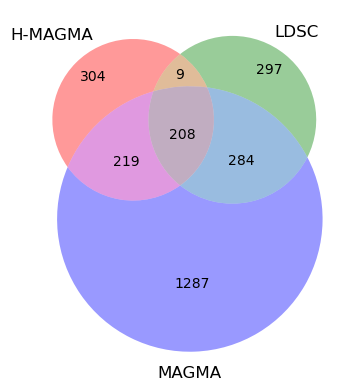

In [67]:
# venn diagram of shared significant annotations between methods
plt.style.use('default')

df_3m = df_all[(df_all.n_methods==3)&(df_all[f'pvalue_{pval_correction}']<=0.05)]
df_3m = df_3m.groupby(['gwas','specificity_id','annotation'])['method'].agg(list).reset_index()
df_3m = df_3m['method'].value_counts().reset_index()
# df_3m.set_index('index', inplace=True)
for m in methods:
    df_3m[m] = df_3m['index'].apply(lambda x : m in x)
df_3m.drop(columns='index', inplace=True)

true_false_list = [
    (True,False,False),
    (False,True,False),
    (True,True,False),
    (False,False,True),
    (True,False,True),
    (False,True,True),
    (True,True,True)
]
venn_values = []
for a,b,c in true_false_list:
    venn_values.append(
        df_3m[(df_3m[methods[0]]==a)&(df_3m[methods[1]]==b)&(df_3m[methods[2]]==c)]['method'].values[0]
    )

venn_values
v = venn3(subsets = venn_values, 
          set_labels = (methods))
# change the colors...
# v.get_patch_by_id('100').set_color('#4A148C')
# v.get_patch_by_id('110').set_color('#9C27B0')
# v.get_patch_by_id('010').set_color('#CE93D8')
# v.get_patch_by_id('001').set_color('#9C27B0')
# v.get_patch_by_id('011').set_color('#4A148C')
# v.get_patch_by_id('111').set_color('#')
# plt.title(name)
plt.savefig(f"{out_dir}venn_methods_significant_annot.png", dpi=200, bbox_inches='tight')
plt.show()

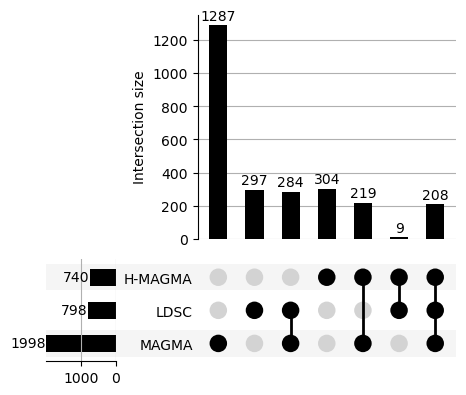

In [35]:
import upsetplot
df_upset = df_3m.set_index(methods)
upsetplot.plot(df_upset['method'], show_percentages=False,
               sort_by='degree', with_lines=True, #cardinality, degree
               element_size=36, 
               show_counts='%d'
              )
plt.savefig(f"{out_dir}upsetplot_methods_significant_annot.png", dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
v = venn3(subsets = df_3m.values(), 
          set_labels = (methods))

In [ ]:
# histograms of beta per method
plt.style.use('seaborn')

fig, axes = plt.subplots(len(methods), figsize=(7,7), sharey=True)
for ax,m in zip(axes,methods):
    df_all[(df_all.method==m)].beta.hist(bins=200, ax=ax, label=m, color=method_color[m])
    ax.legend()
fig.tight_layout()
    

In [ ]:
# 3d scatter plot of beta values per method
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
mline = df_all[(df_all.n_methods==3)&(df_all.method=='MAGMA')].beta
hmline = df_all[(df_all.n_methods==3)&(df_all.method=='H-MAGMA')].beta
lline = df_all[(df_all.n_methods==3)&(df_all.method=='LDSC')].beta
ax.scatter(mline, hmline, lline, lw=.1, alpha=.5)
fig.tight_layout()
plt.show()

['DTI MO: CGC',
 'DTI RD: FXST',
 'Net100_Pair7_11',
 'SCZ_2014',
 'Net100_Pair18_35',
 'PGC_depression2019',
 'DTI PC1: IFO',
 'Net100_Pair5_25',
 'Net100_Pair23_41',
 'ASD_2019',
 'DTI PC1: CGC',
 'BIP_PGC3',
 'DTI RD: IFO',
 'DTI FA: CGC',
 'InstantCoffee_2019',
 'DTI PC1: SLF',
 'DTI FA: IFO',
 'surface area: Cortex.cortex',
 'DTI PC1: EC',
 'DTI AD: BCC',
 'DTI FA: EC',
 'Net100_Pair34_48',
 'SCZ_2016',
 'Net100_Pair21_29',
 'DTI FA: SLF',
 'BMI_GIANT2018']

In [553]:
# scatter plot of GWAS 'a' and with all other significant correlated GWASes ('b')

plt.style.use('seaborn')
plot_annots = True
# a = 'volume: accumbens'
# a = 'volume: caudate'
# a = 'SCZ_2016'
a = 'SCZ_PGC3_2020'

cy = 'blue'
cx = 'red'
for m in methods:
    corr_df = corr_pears_methods_dict[m].copy()
    b_list = list(set(corr_df[((corr_df['gwasx']==a)|(corr_df['gwasy']==a))&(corr_df['pval']<get_pthres(corr_df))][['gwasx','gwasy']].values.flatten()))
    b_list.remove(a)
    
    for i,b in enumerate(b_list):
        filename = f"{out_dir}correlation_{make_filename(a)}/{make_filename(a)}_vs_{make_filename(b)}_{m}_correlation_pearson.png"
        if not Path(filename).exists():
            fig, ax = plt.subplots(figsize=(10,10))
            ax.axhline(0, color='white', zorder=0, lw=3)
            ax.axvline(0, color='white', zorder=0, lw=3)
            ax.axline(xy1=(0,0), slope=1, color='white', zorder=0, lw=3)
            x,y = [df_all[(df_all.gwas==j)&(df_all.method==m).copy()]
                   for j in [a,b]]
            ax.scatter(x.beta, y.beta, label=m, color=method_color[m], alpha=.4)
            
            x = x.assign(sign = lambda x: (x[f'pvalue_{pval_correction}'] <= 0.05))
            y = y.assign(sign = lambda x: (x[f'pvalue_{pval_correction}'] <= 0.05))
#             x['sign'] = (x[f'pvalue_{pval_correction}'] <= 0.05)
#             y['sign'] = (y[f'pvalue_{pval_correction}'] <= 0.05)
            
            # is really slow because of the annotations
            if plot_annots:
                texts_xy = [ax.annotate(annot, (x.beta.iat[l], y.beta.iat[l]),color='green',fontsize=8)
                         for l,annot in enumerate(x.annotation) if x.sign.iat[l] and y.sign.iat[l]]
                texts_x = [ax.annotate(annot, (x.beta.iat[l], y.beta.iat[l]),color=cx,fontsize=8)
                         for l,annot in enumerate(x.annotation) if x.sign.iat[l] and not y.sign.iat[l] ]
                texts_y = [ax.annotate(annot, (x.beta.iat[l], y.beta.iat[l]),color=cy,fontsize=8)
                         for l,annot in enumerate(x.annotation) if y.sign.iat[l] and not x.sign.iat[l] ]
                adjust_text(texts_xy+texts_x+texts_y, lim=200, arrowprops=dict(arrowstyle='->', color='black'))

            print(f'Plot {i+1}/{len(b_list)}...')
            plt.title(m)
            
            ax.set_xlabel(a, fontsize=10, color=cx)
            ax.set_ylabel(b, fontsize=10, color=cy)

            corr_val = corr_df[((corr_df['gwasx']==a)&(corr_df['gwasy']==b))
                               |
                               ((corr_df['gwasx']==b)&(corr_df['gwasy']==a))]['corr'].values
            ax.text(0.12, 0.97, f'Cell-type Correlation  = {float(corr_val):.2f}', horizontalalignment='center',
                 verticalalignment='center', transform = ax.transAxes)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            Path(f"{out_dir}correlation_{make_filename(a)}").mkdir(parents=True, exist_ok=True)
            plt.savefig(filename, dpi=200, bbox_inches='tight')
#             plt.show()
            plt.close(fig)
#         break


Plot 1/26...
Plot 2/26...
Plot 3/26...
Plot 4/26...
Plot 5/26...
Plot 6/26...
Plot 7/26...
Plot 8/26...
Plot 9/26...
Plot 10/26...
Plot 11/26...
Plot 12/26...
Plot 13/26...
Plot 14/26...
Plot 15/26...
Plot 16/26...
Plot 17/26...
Plot 18/26...
Plot 19/26...
Plot 20/26...
Plot 21/26...
Plot 22/26...
Plot 23/26...
Plot 24/26...
Plot 25/26...
Plot 26/26...
Plot 1/8...
Plot 2/8...
Plot 3/8...
Plot 4/8...
Plot 5/8...
Plot 6/8...
Plot 7/8...
Plot 8/8...
Plot 1/9...
Plot 2/9...
Plot 3/9...
Plot 4/9...
Plot 5/9...
Plot 6/9...
Plot 7/9...
Plot 8/9...
Plot 9/9...


/home/eerdem/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: The handle <BarContainer object of 7 artists> has a label of '__' which cannot be automatically added to the legend.


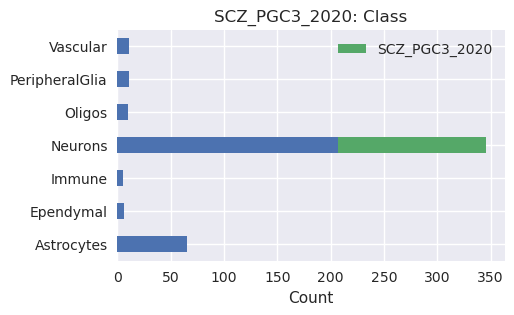

/home/eerdem/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: The handle <BarContainer object of 8 artists> has a label of '__' which cannot be automatically added to the legend.


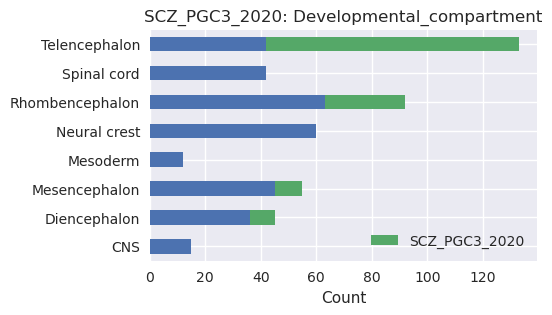

/home/eerdem/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: The handle <BarContainer object of 12 artists> has a label of '__' which cannot be automatically added to the legend.


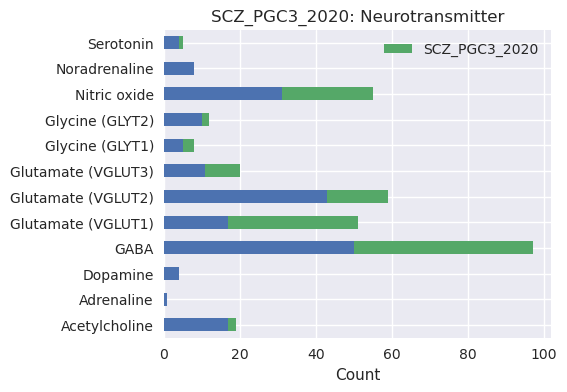

/home/eerdem/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: The handle <BarContainer object of 24 artists> has a label of '__' which cannot be automatically added to the legend.


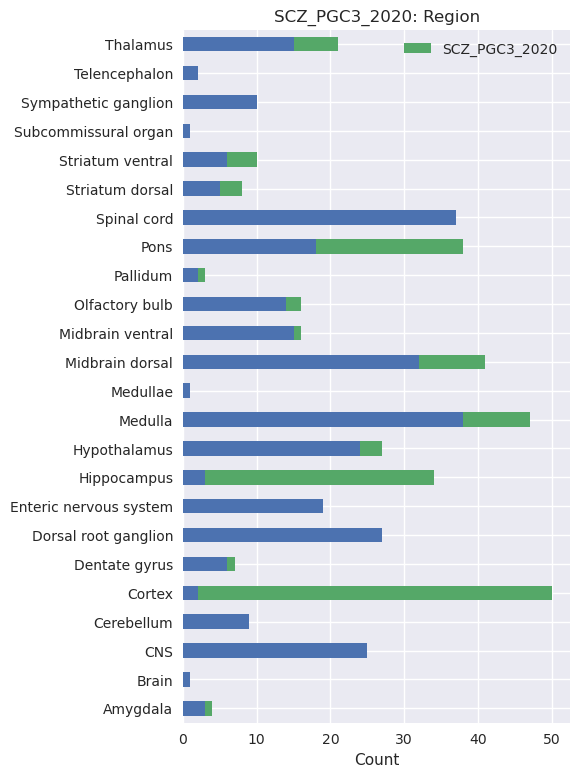

In [204]:
# bar plots of mousebrain data

# a = 'volume: caudate'
# a = 'MD: SS'
# a = 'MD: PTR'
# a = 'volume: Parietal.postcentral'
# a = 'SCZ_2016'
# a = 'PGC_depression2019'
a = "SCZ_PGC3_2020"


plt.style.use('seaborn')
def explode_column(df, column, split_str=','):
    df = df.set_index(
            df.drop([column],axis=1).columns.to_list()
        )[[column]].apply(lambda x: x.str.split(',').explode()).reset_index()
    df[column] = df[column].str.strip()
    return df

ylab = ["Class", "Developmental_compartment", "Neurotransmitter","Region"]
heights = [3,3,4,9]

#use mousebrain metadata to infer more info
file = "/home/eerdem/notebooks/CELLECT-Analyser/mousebrain_celltype_metadata.csv"
mb_metadata_df = pd.read_csv(file)
mb_metadata_df.Neurotransmitter.replace("(\w+) (\(\w+),\s*(\w+\))",r"\1 \2), \1 (\3", regex=True, inplace=True) #to fix wrong explode
mb_metadata_df['Type'] = 'All'
mb_metadata_df = explode_column(mb_metadata_df,'Neurotransmitter')
mb_metadata_df = explode_column(mb_metadata_df,'Region')
mb_metadata_df = explode_column(mb_metadata_df,'Developmental_compartment')
# mb_metadata_df = explode_column(mb_metadata_df,'Probable_location')
adf = df_all[(df_all.gwas==a)&(df_all.specificity_id=='mousebrain')]
annot_list = adf[adf[f'pvalue_{pval_correction}'] <= 0.05].annotation.to_list()
mb_metadata_df.loc[mb_metadata_df.ClusterName.isin(annot_list), 'Type'] = a

for height,y in zip(heights,ylab):
    ax = mb_metadata_df[[y,'Type']].groupby([y,'Type']).size().reset_index()\
    .pivot_table(values=0, index=y, columns='Type').plot.barh(stacked=True, legend=False, figsize=(5,height))
    ax.legend(['__',a])
    ax.set_ylabel('')
    ax.set_xlabel('Count')
    plt.title(f'{a}: {y}')
#     plt.savefig(f"{out_dir}{name}/{name}_mousebrain_{y}.png", dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
# bar plots of mousebrain data
plt.style.use('seaborn')

# a = 'volume: caudate'
# a = 'MD: SS'
# a = 'MD: PTR'
# a = 'volume: Parietal.postcentral'
a = 'SCZ_2016'
# a = 'PGC_depression2019'
adf = df_all[(df_all.gwas==a)&(df_all.specificity_id=='mousebrain')]
sign_adf = adf[adf[f'pvalue_{pval_correction}'] <= 0.05]
annot_list = sign_adf.annotation.to_list()

#use mousebrain metadata to infer more info
annot_list
file = "/home/eerdem/notebooks/CELLECT-Analyser/mousebrain_celltype_metadata.csv"
mb_metadata_df = pd.read_csv(file)
sign_annot_df = mb_metadata_df[mb_metadata_df.ClusterName.isin(annot_list)]

mb_metadata_df['Type'] = 'All'
mb_metadata_df.loc[mb_metadata_df.ClusterName.isin(annot_list), 'Type'] = a
mb_metadata_df.Developmental_compartment.replace('Diencephalon,Mesencephalon,Rhombencephalon,Spinal cord',
                                                  'Diencephalon,Mesencephalon,Rhombencephalon,Spinal cord'.replace(',','\n'),
                                                   inplace=True)

ylab = ["Class", "Developmental_compartment", "Neurotransmitter","Region", "Probable_location"]
heights = [5,5,8,9,20]
for height,y in zip(heights,ylab):  
    mb_metadata_df[[y,'Type']].groupby([y,'Type']).size().reset_index()\
    .pivot_table(values=0, index=y, columns='Type').plot.barh(stacked=True, legend=False, figsize=(5,height))
    plt.legend(['__',a])
    plt.ylabel('')
    plt.xlabel('Count')
    plt.title(y)
#     plt.savefig(f"{out_dir}{name}/{name}_mousebrain_{y}.png", dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()

# UMAP clustering

In [ ]:
df_all.gwas.unique()

In [ ]:
import umap
df_all_umap = df_all.copy()
# df_all_umap['cluster'] = df_all_umap.gwas.str.extract(r'(.+\: \w+)\.\w+')
df_all_umap.loc[df_all_umap.gwas.str.contains('volume'), 'cluster'] = 'Volume'
df_all_umap.loc[df_all_umap.gwas.str.contains('cortical'), 'cluster'] = 'Cortical thickness'
df_all_umap.loc[df_all_umap.gwas.str.contains('surface'), 'cluster'] = 'Surface Area'

# df.loc[df.gwas.str.contains('Node'), 'cluster'] = 'Node'
df_all_umap.loc[df_all_umap.gwas.str.contains('Net100_Node'), 'cluster'] = 'fMRI'
df_all_umap.loc[df_all_umap.gwas.str.contains('Net25_Node'), 'cluster'] = 'fMRI'
df_all_umap.loc[df_all_umap.gwas.str.contains('Net100_Pair'), 'cluster'] = 'fMRI'
df_all_umap.loc[df_all_umap.gwas.str.contains('Net25_Pair'), 'cluster'] = 'fMRI'
# df_all_umap.loc[df_all_umap.gwas.str.contains('Pair'), 'cluster'] = 'Connectivity'
df_all_umap.loc[df_all_umap.gwas.str.contains('Edge'), 'cluster'] = 'fMRI'

df_all_umap.loc[df_all_umap.gwas.str.contains('FA'), 'cluster'] = 'DTI'
df_all_umap.loc[df_all_umap.gwas.str.contains('MD'), 'cluster'] = 'DTI'
df_all_umap.loc[df_all_umap.gwas.str.contains('MO'), 'cluster'] = 'DTI'
df_all_umap.loc[df_all_umap.gwas.str.contains('AD'), 'cluster'] = 'DTI'
df_all_umap.loc[df_all_umap.gwas.str.contains('RD'), 'cluster'] = 'DTI'
df_all_umap.loc[df_all_umap.gwas.str.contains('PC'), 'cluster'] = 'DTI'


df_all_umap = df_all_umap.fillna('Misc')
df_dropped = df_all_umap[df_all_umap.n_methods==3]

# df_dropped = df_dropped[df_dropped.cluster.isin(['Surface Area','Volume'])]

df_beta = df_dropped.pivot_table(values='beta', index='gwas',columns=['specificity_id','annotation','method'])\
            .dropna(axis=1)

In [ ]:
annot = False
plt.style.use('dark_background')
standard_embedding = umap.UMAP(metric='correlation').fit_transform(df_beta)

clusters = df_dropped.drop_duplicates(subset=['gwas'])[['cluster']]
df_umap = pd.DataFrame(standard_embedding, columns=['x','y'])
df_umap['cluster'] = clusters.reset_index()['cluster']
df_umap['gwas'] = df_dropped.drop_duplicates(subset=['gwas']).reset_index()['gwas']

# cmap = plt.get_cmap('Set1')
cmap = plt.get_cmap('hsv')

colors = cmap(np.linspace(0, 1, len(df_umap.cluster.unique())+1))
color_dict = {k:v for k,v in zip(df_umap.cluster.unique(),colors)}
fig, ax = plt.subplots(figsize=(15,15))
annots = []
for k,d in df_umap.groupby('cluster'):
    d = d.reset_index().drop('index',axis=1)
    ax.scatter(d['x'], d['y'], label=k, s=20, color=color_dict[k])
    if annot:
        annots.append([ax.annotate(annot[annot.find(':')+1:], (d['x'][i], d['y'][i]),  rotation=0, size=8) 
                  for i,annot in enumerate(d['gwas'])])
if annot:
    adjust_text([a for annot_sub in annots for a in annot_sub], lim=200,arrowprops=dict(arrowstyle='->', color='white'))

plt.legend()
plt.grid(b=None)
plt.axis('off')
plt.title('UMAP projection of GWAS beta values')
# plt.savefig(f"{out_dir}UMAP_GWAS_beta.png", dpi=200, bbox_inches='tight')
plt.show()

# Network Graph

In [ ]:
lhead = links.sort_values(by='value').head().var2.to_list()
ltail = links.sort_values(by='value').tail().var2.to_list()
links
links[(links.var1.isin(lhead))|(links.var1.isin(ltail))]

In [ ]:
import networkx as nx

df_all_pivot = df_all[(df_all.method=='MAGMA')
#                                &~(df_all.gwas.str.contains('FA|MD|PC|RD|AD|MO',case=True, regex=True))
                              ]\
.pivot_table(index='annotation', columns='gwas', values='beta')
df_all_pivot.dropna(axis='columns', inplace=True)
df_all_corr = df_all_pivot.corr()
df_all_corr.rename_axis(None)
df_all_corr.columns.names = [None]

links = df_all_corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# lhead = links.sort_values(by='value').head(10).var2.to_list()
# ltail = links.sort_values(by='value').tail(10).var2.to_list()
# links = links[(links.var1.isin(lhead))|(links.var1.isin(ltail))]

links_filtered = links.loc[ (links['value'] > 0.6) & (links['var1'] != links['var2']) ]
links_filtered

# Build your graph
G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 
# Plot the network:
# nx.draw(G, with_labels=True, node_color='orange', node_size=10, edge_color='black', linewidths=1, font_size=7)
pos = nx.spring_layout(G, k=1, iterations=200)
# nx.draw(G, pos, with_labels=True, font_size=8, node_size=50, linewidths=.3)
nx.draw_circular(G ,with_labels=True, font_size=8, node_size=50, linewidths=.3)

# GSA

In [ ]:
# check which annotation is most common among a group of GWAS
# gwas_regex_term = '' # to check all GWAS
gwas_regex_term = 'Net'
max_annot_df = df_all[(df_all.gwas.str.contains(gwas_regex_term))&(df_all[f'pvalue_{pval_correction}']<=0.05)]\
.groupby(['method','specificity_id','annotation']).size().reset_index()\
.sort_values(by=0, ascending=False).drop_duplicates(['method'])
display(max_annot_df)
dataset, celltype = max_annot_df.max()[['specificity_id','annotation']]

In [ ]:
cellex_file = f'/home/eerdem/CELLECT/example/CELLEX_DATA/{dataset}.mu.csv' # change esmu to mu if file not found
df_esmu = pd.read_csv(cellex_file, index_col=0)
display(df_esmu)
df_esmu[celltype][df_esmu[celltype]!=0].hist()
plt.title(celltype)
plt.xlabel('ES\u03bc (excluding 0)')
plt.show()

In [ ]:
import mygene

ens = df_esmu[[celltype]][df_esmu[celltype]>0.4].sort_values(by=celltype).index.to_list()
mg = mygene.MyGeneInfo()
ginfo = mg.querymany(ens, scopes='ensembl.gene')
gene_list = [g['symbol'] for g in ginfo if 'symbol' in g]


In [ ]:
import gseapy
from gseapy.plot import barplot, dotplot, gseaplot

names = gseapy.get_library_name() # default: Human
names

In [ ]:
# gene_sets = 'Jensen_DISEASES'
# gene_sets = 'Reactome_2016'
# gene_sets = 'GO_Biological_Process_2018'
# gene_sets = 'GWAS_Catalog_2019'
# gene_sets = 'UK_Biobank_GWAS_v1'
# gene_sets = 'BioCarta_2016'
gene_set_list = [
                 'BioCarta_2016',
                 'Chromosome_Location_hg19',
                 'ClinVar_2019',
                 'DisGeNET',
                 'Disease_Perturbations_from_GEO_down',
                 'Disease_Perturbations_from_GEO_up',
                 'GO_Biological_Process_2018',
                 'GO_Cellular_Component_2018',
                 'GO_Molecular_Function_2018',
                 'GWAS_Catalog_2019',
                 'Jensen_COMPARTMENTS',
                 'Jensen_DISEASES',
                 'Jensen_TISSUES',
                 'KEGG_2019_Human',
                 'OMIM_Disease',
                 'OMIM_Expanded',
                 'ProteomicsDB_2020',
                 'Reactome_2016',
                 'UK_Biobank_GWAS_v1',
                 'WikiPathways_2019_Human'
                ]
Path(f'{out_dir}/{celltype}/').mkdir(parents=True, exist_ok=True)
for gene_sets in gene_set_list:
    print(gene_sets)
    file_name = f'{out_dir}/{celltype}/enrichr_{gene_sets}_{celltype}.png'
    if not Path(file_name).is_file(): # skips if file already exist
        enr = gseapy.enrichr(gene_list=gene_list,
                         gene_sets=gene_sets,
#                          outdir=f'test/enrichr_{celltype}_{gene_sets}',
                         outdir=None,
                        )
        dotplot(enr.res2d, title=f'{celltype}\nGene-set:{gene_sets}',
                ofname=file_name)

# enr.results[enr.results['Adjusted P-value']<0.05]